### Configurations

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import logging
import pandas as pd
import numpy as np
import graphviz
import pydotplus
import pickle
import re
from scipy import stats

from importlib.machinery import SourceFileLoader

import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go

from IPython.display import Image

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.feature_selection import SelectKBest,chi2
from sklearn.metrics import classification_report

from tensorflow.keras import Sequential,Model

from tensorflow.keras.layers import (Dense,\
                                     Input,\
                                     Embedding,\
                                     concatenate,\
                                     BatchNormalization,\
                                     Dropout,\
                                     Conv1D,\
                                     Flatten)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop


from IPython.display import Image


In [ ]:
!pip install cloud-tpu-client

In [3]:
logging.basicConfig(level='DEBUG')


logger = logging.getLogger()


PROJECT_PATH = os.path.join(os.getcwd(),\
                            'drive',\
                            'MyDrive',\
                            'Datasets',\
                            'Kaggle',\
                            'TelestraNetworkOutagePrediction')
logger.debug(f'directory has {os.listdir(PROJECT_PATH)}')

LIBRARY_PATH = os.path.join(os.getcwd(),\
                            'drive',\
                            'MyDrive',\
                            'mylib')
logger.debug(f'directory has {os.listdir(LIBRARY_PATH)}')


logger.debug(f"max col width setting is {pd.\
            get_option('display.max_colwidth')}")
pd.set_option('display.max_colwidth',100)

logger.debug(f"max columns setting is {pd.\
            get_option('display.max_columns')}")
pd.set_option('display.max_columns',100)

logger.debug(f"display.float fomat is {pd.\
            get_option('display.float_format')}")
pd.set_option('display.float_format', '{:.3f}'.format)

logger.debug(f'Default renderer is {pio.renderers}')
#Setting renderer
pio.renderers.default = 'colab'
logger.debug(f'New renderer is {pio.renderers}')


DEBUG:root:directory has ['train.csv', 'test.csv', 'severity_type.csv', 'log_feature.csv', 'sample_submission.csv', 'event_type.csv', 'resource_type.csv', 'model', 'test_preds', 'eval', 'images']
DEBUG:root:directory has ['__pycache__', 'feature_engineering.py', 'model_building.py', 'eda.py', 'eval.py']
DEBUG:root:max col width setting is 50
DEBUG:root:max columns setting is 0
DEBUG:root:display.float fomat is None
DEBUG:root:Default renderer is Renderers configuration
-----------------------
    Default renderer: 'colab'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery']

DEBUG:root:New renderer is Renderers configuration
-----------------------
    Default renderer: 'colab'
    Available render

In [4]:
eda = SourceFileLoader('eda',\
                        os.path.join(LIBRARY_PATH,\
                                     'eda.py')).load_module()

eval = SourceFileLoader('eval',\
                        os.path.join(LIBRARY_PATH,\
                                     'eval.py')).load_module()

mb = SourceFileLoader('model_building',\
                        os.path.join(LIBRARY_PATH,\
                                     'model_building.py')).load_module()

fe = SourceFileLoader('feature_engineering',\
                        os.path.join(LIBRARY_PATH,\
                                     'feature_engineering.py')).load_module()

In [5]:
el = eval.ClassificationEvaluation()
el.load_data(os.path.join(PROJECT_PATH,'eval','eval.csv'))
logger.debug(f'Here is the loaded metric file \n {el.get_metrics()}')

DEBUG:root:Here is the loaded metric file 
                                 model  train_accuracy  train_recall  \
0                NaiveBayesStrategy5a           0.521         0.573   
1              DecisionTreeStrategy5a           0.820         0.743   
2              RandomForestStrategy5a           0.742         0.761   
3   RandomForestTopFeaturesStrategy5a           0.792         0.815   
4                   XGBoostStrategy5a           0.840         0.883   
5        XGBoostTopFeaturesStrategy5a           0.843         0.885   
6                  StackingStrategy5a           0.819         0.731   
7                NaiveBayesStrategy3a           0.622         0.723   
8              DecisionTreeStrategy3a           0.803         0.689   
9              RandomForestStrategy3a           0.871         0.817   
10  RandomForestTopFeaturesStrategy3a           0.872         0.819   
11                  XGBoostStrategy3a           0.925         0.952   
12       XGBoostTopFeaturesStrate

In [6]:
def predict_test(model,X_test,test_ids,\
                 model_desc,PROJECT_PATH):
  '''
  predicts and create a sample csv for later use
  '''
  x_test_pred = model.predict_proba(X_test)
  x_test_pred = pd.DataFrame(x_test_pred,\
                          columns=['predict_0',\
                                   'predict_1',\
                                   'predict_2'],\
                          index=test_ids.index)
  test_ids = test_ids.astype('int64')
  x_test_out = pd.concat([test_ids,x_test_pred],axis=1)
  x_test_out.columns = ['id','predict_0','predict_1','predict_2']
  file_name = model_desc + '.csv'
  x_test_out.to_csv(os.path.join(PROJECT_PATH,'test_preds',file_name),\
                    index = False)

  return  x_test_out

### Problem Statement

The goal of the problem is to predict Telstra network's fault severity at a time at a particular location based on the log data available. Each row in the main dataset (train.csv, test.csv) represents a location and a time point. They are identified by the "id" column, which is the key "id" used in other data files. 

Fault severity has 3 categories: 0,1,2 (0 meaning no fault, 1 meaning only a few, and 2 meaning many). 

Different types of features are extracted from log files and other sources: event_type.csv, log_feature.csv, resource_type.csv, severity_type.csv. 

Note: “severity_type” is a feature extracted from the log files (in severity_type.csv). Often this is a severity type of a warning message coming from the log. "severity_type" is categorical. It does not have an ordering. “fault_severity” is a measurement of actual reported faults from users of the network and is the target variable (in train.csv).

File descriptions
- train.csv - the training set for fault severity
- test.csv - the test set for fault severity
- sample_submission.csv - a sample submission file in the correct format
- event_type.csv - event type related to the main dataset
- log_feature.csv - features extracted from log files
- resource_type.csv - type of resource related to the main dataset
- severity_type.csv -  severity type of a warning message coming from the log

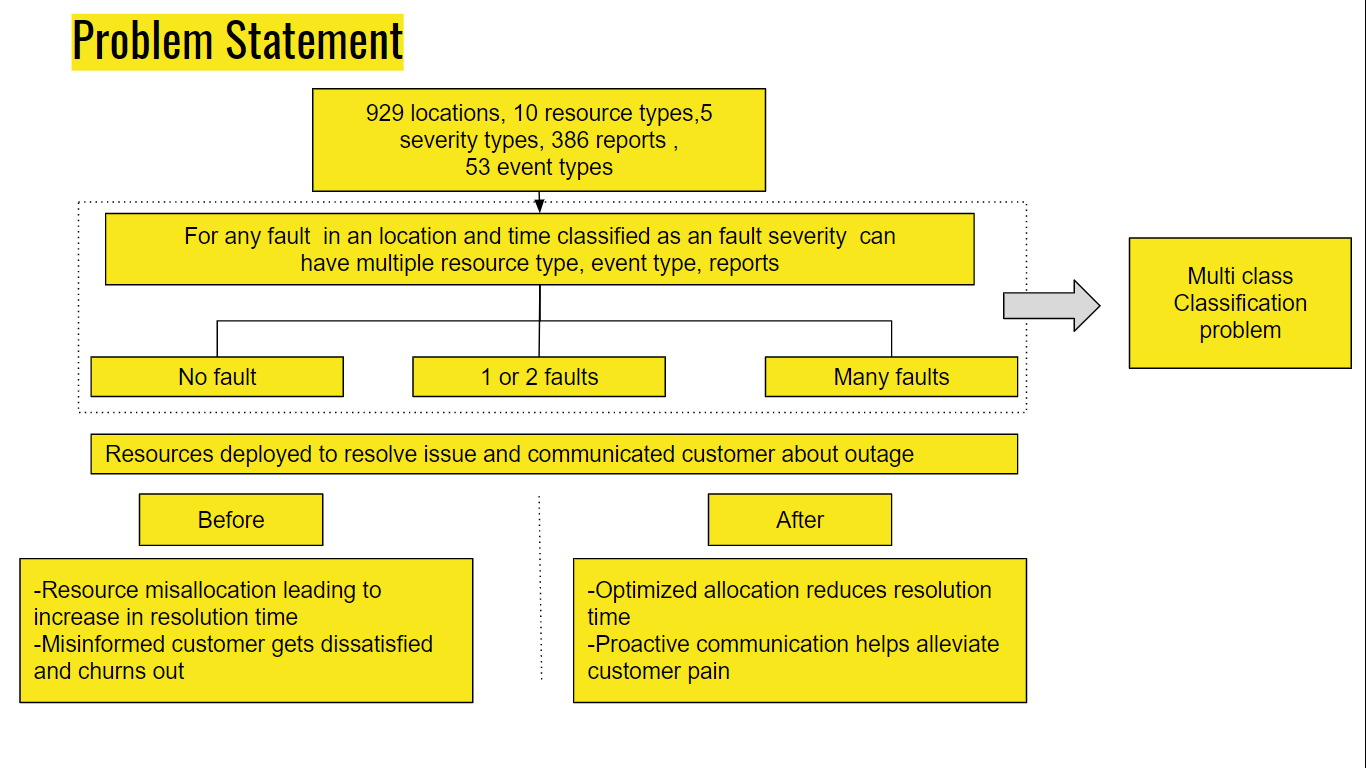

In [7]:
Image(os.path.join(PROJECT_PATH,'images','ProblemStatement.png'))

### Data exploration

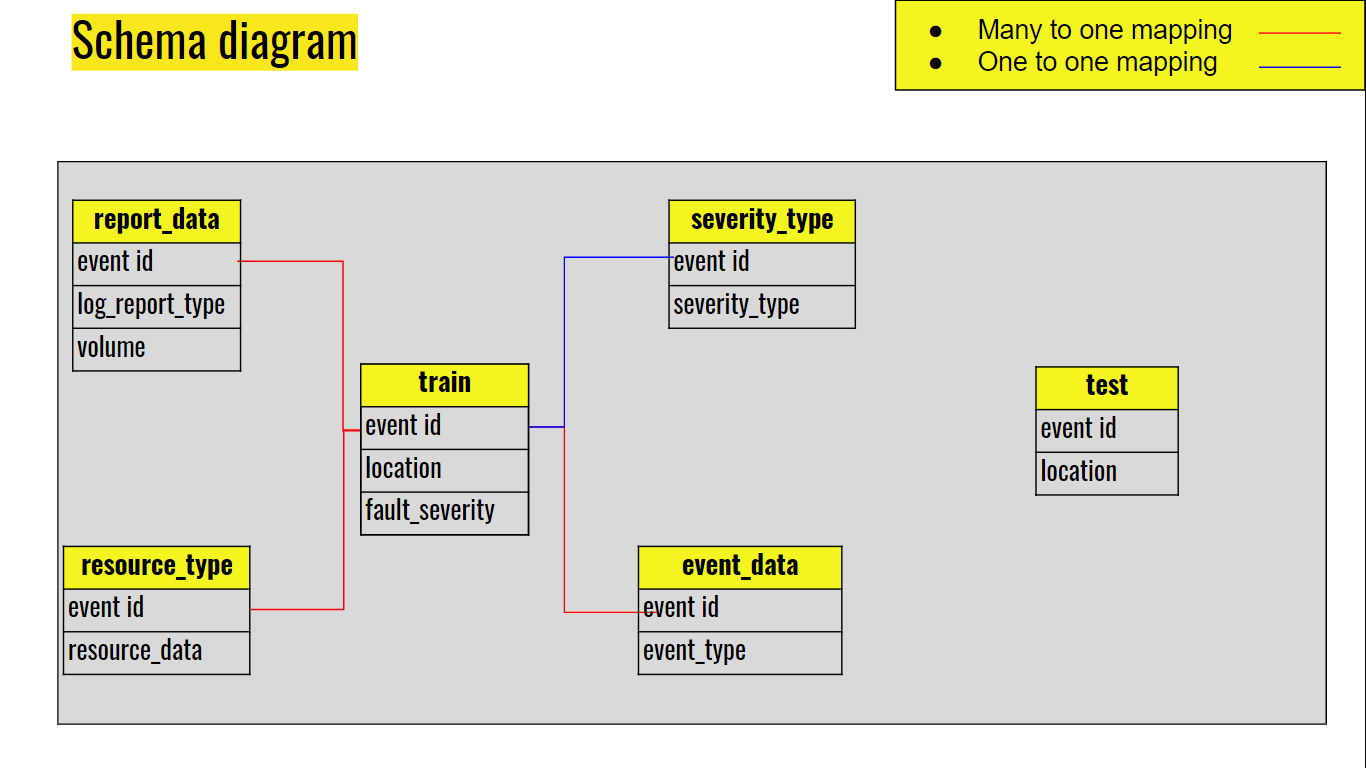

In [8]:
Image(os.path.join(PROJECT_PATH,'images','Schema.png'))

In [9]:
logger.debug(f'Files in directory are {os.listdir(PROJECT_PATH)}')

DEBUG:root:Files in directory are ['train.csv', 'test.csv', 'severity_type.csv', 'log_feature.csv', 'sample_submission.csv', 'event_type.csv', 'resource_type.csv', 'model', 'test_preds', 'eval', 'images']


#### ``train_data``

The different volume of fault severity are as follows

- `0` for no faults
- `1` for few faults
- `2` for many faults

Below are highlights of this dataset

- Details of `7381` event_id across location and fault_severity

In [10]:
logger.debug('Importing train.csv')
train_data = pd.read_csv(os.path.join(PROJECT_PATH,'train.csv'))
eda.explain_data(train_data)

DEBUG:root:Importing train.csv
INFO:numexpr.utils:NumExpr defaulting to 2 threads.


The data has 7381 rows and 3 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,int64,0,7381,7381.000,NaN,NaN,NaN,9264.649,5349.290,1.000,4647.000,9222.000,13885.000,18550.000
location,object,0,929,7381,929,location 821,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fault_severity,int64,0,3,7381.000,NaN,NaN,NaN,0.450,0.667,0.000,0.000,0.000,1.000,2.000


- `876` unique locations
 - While there are no areas that significantly stand out in terms of events, there are areas with very little representation in events. 
 - `location 821`, `location 1107` and `location 734` reports `>1%` of all events.
 - Each event id is unique to an area code

- 3 different severity types
  - There is a class balance issue with many fault events   reporting 9% of the data.
  - `65%` events identified as no faults, `25%` events as few faults and remaining `9.8%` events as many faults.



In [11]:
for col in train_data.columns.drop('id'):
  eda.plot_one_cat(train_data,col)

In [12]:
#Logging area code wise distribution of events 
logger.info(f"Below is the area code wise distribution in percentages of events\
\n{train_data['location'].value_counts(normalize=True)*100}")

INFO:root:Below is the area code wise distribution in percentages of events
location 821    1.152
location 1107   1.057
location 734    1.016
location 126    0.962
location 1008   0.962
                 ... 
location 824    0.014
location 860    0.014
location 588    0.014
location 1074   0.014
location 59     0.014
Name: location, Length: 929, dtype: float64


In [13]:
multi_value_keys = eda.get_multi_value_keys(train_data,'id','location')
logger.info(f'Multi value keys along with their frequencies {multi_value_keys}')

INFO:root:Multi value keys along with their frequencies Series([], Name: location, dtype: int64)



There are 0 multivalue keys 



- Out of `876` location, 
 - `454` observed only 1 kind of fault,
 - `357` observed 2 kinds of faults whereas only 
 - `118` areas observed all 3 kinds of faults

In [14]:
faults_per_area = train_data.groupby(['location'])['fault_severity'].nunique()
single_fault_area = len(faults_per_area[faults_per_area == 1])
double_fault_area = len(faults_per_area[faults_per_area == 2])
all_fault_area = len(faults_per_area[faults_per_area == 3])

logger.debug(f' There are {single_fault_area} areas where there was only 1 \
kind of fault was observed \n There are {double_fault_area} areas where \
2 kind of faults were observed and remaining {all_fault_area} observed all 3 kinds of faults')

DEBUG:root: There are 454 areas where there was only 1 kind of fault was observed 
 There are 357 areas where 2 kind of faults were observed and remaining 118 observed all 3 kinds of faults


In [15]:
eda.plot_two_cat(train_data,'location','fault_severity')

In [16]:
for level in train_data['fault_severity'].unique():
  print(f'Printing for fault = {level}')
  eda.plot_one_cat(train_data[train_data['fault_severity'] == level],'location')

Printing for fault = 1


Printing for fault = 0


Printing for fault = 2


In [17]:
area_wise_severity = (pd.\
                      crosstab(train_data['location'],\
                               train_data['fault_severity'].\
                               astype('object'),
                               normalize='index').\
                      reset_index())
area_wise_severity.columns = ['location_'+ str(i) for i in area_wise_severity.columns]


In [18]:
logger.debug(f'Shape of train_data is {train_data.shape}')
train_data = pd.merge(train_data,\
                      area_wise_severity,\
                      left_on='location',\
                      right_on='location_location',\
                      how='left')

faults_per_area = faults_per_area.reset_index()
faults_per_area.columns = ['location','event_count']

events_per_area = train_data['location'].\
value_counts(normalize=True).reset_index()
events_per_area.columns = ['location','location_count_perc']

train_data = pd.merge(train_data,faults_per_area,\
                      on='location',\
                      how='left')
train_data = pd.merge(train_data,events_per_area,\
                      on='location',\
                      how='left')

train_data.drop('location_location',inplace=True,axis=1)
logger.debug(f'Shape of train_data is {train_data.shape}')

DEBUG:root:Shape of train_data is (7381, 3)
DEBUG:root:Shape of train_data is (7381, 8)


In [19]:
fig = px.box(train_data,\
             x='fault_severity',\
             y='location_count_perc',\
             title='# of events in an area vs Outage duration')
fig.show()

- Added a new dimension ‘top_location’ to bucketize area_codes as per pareto.
25% of areas bucketized into ‘top_location.


In [20]:
train_data,top_area_codes = eda.bucketize_pareto(train_data,
                                             'location',
                                             'fault_severity',
                                             .80)
eda.explain_data(train_data)

281 ids identified in the Top 80.0% pareto
The data has 7381 rows and 9 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,int64,0,7381,7381.000,NaN,NaN,NaN,9264.649,5349.290,1.000,4647.000,9222.000,13885.000,18550.000
location,object,0,929,7381,929,location 821,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fault_severity,object,0,3,7381.000,3.000,0.000,4784.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location_0,float64,0,116,7381.000,NaN,NaN,NaN,0.648,0.297,0.000,0.397,0.667,1.000,1.000
location_1,float64,0,110,7381.000,NaN,NaN,NaN,0.253,0.232,0.000,0.000,0.250,0.385,1.000
location_2,float64,0,63,7381.000,NaN,NaN,NaN,0.098,0.164,0.000,0.000,0.000,0.158,1.000
event_count,int64,0,3,7381.000,NaN,NaN,NaN,2.067,0.784,1.000,1.000,2.000,3.000,3.000
location_count_perc,float64,0,60,7381.000,NaN,NaN,NaN,0.003,0.003,0.000,0.001,0.003,0.005,0.012
top_location,object,0,282,7381,282,other_location,1864,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
eda.plot_two_cat(train_data,'top_location','fault_severity')

In [22]:
#Excluding 'other_area_code' to understand the distribution 
eda.plot_one_cat(train_data[train_data['top_location'] != 'other_location'],\
             'top_location')

#### ``test_data``

- Details of `11171` event_id across area codes

In [23]:
logger.debug('test data.csv')
test_data = pd.read_csv(os.path.join(PROJECT_PATH,'test.csv'))
eda.explain_data(test_data)

DEBUG:root:test data.csv


The data has 11171 rows and 2 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,int64,0,11171,11171.000,NaN,NaN,NaN,9284.330,5360.065,2.000,4630.000,9316.000,13926.000,18552.000
location,object,0,1039,11171,1039,location 734,109,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- `1039` unique area codes
  - Distribution almost similar to test_data does not have peaks similar to train_data
  - 197 area_code present in test_data but not in train_data
  - Each event id is unique to an area code



In [24]:
eda.plot_one_cat(test_data,'location')

In [25]:
#Logging area code wise distribution of events 
logging.info(f"Below is the area code wise distribution in percentages of events\
\n {test_data['location'].value_counts(normalize=True)*100}")

INFO:root:Below is the area code wise distribution in percentages of events
 location 734    0.976
location 653    0.967
location 1107   0.949
location 126    0.949
location 704    0.913
                 ... 
location 231    0.009
location 585    0.009
location 852    0.009
location 935    0.009
location 59     0.009
Name: location, Length: 1039, dtype: float64


In [26]:
multi_value_keys = eda.get_multi_value_keys(test_data,'id','location')
logger.info(f'Multi value keys along with their frequencies {multi_value_keys}')

INFO:root:Multi value keys along with their frequencies Series([], Name: location, dtype: int64)



There are 0 multivalue keys 



In [27]:
test_area_code_set = set(test_data['location'].unique())
train_area_code_set = set(train_data['location'].unique())

diff_area_code = test_area_code_set - train_area_code_set
logger.debug(f'Below {len(diff_area_code)} area_codes are present in test but not \
present in train data \n {diff_area_code}')

DEBUG:root:Below 197 area_codes are present in test but not present in train data 
 {'location 138', 'location 586', 'location 80', 'location 594', 'location 620', 'location 227', 'location 952', 'location 212', 'location 428', 'location 31', 'location 275', 'location 728', 'location 630', 'location 1043', 'location 569', 'location 965', 'location 25', 'location 1003', 'location 1012', 'location 121', 'location 111', 'location 201', 'location 452', 'location 383', 'location 685', 'location 575', 'location 907', 'location 554', 'location 454', 'location 308', 'location 791', 'location 747', 'location 431', 'location 207', 'location 1124', 'location 605', 'location 993', 'location 591', 'location 43', 'location 482', 'location 412', 'location 689', 'location 598', 'location 142', 'location 411', 'location 552', 'location 61', 'location 486', 'location 327', 'location 858', 'location 542', 'location 612', 'location 372', 'location 992', 'location 572', 'location 920', 'location 910', 'loc

In [28]:
logger.debug(f'Shape for test_data is {test_data.shape}')
test_data = pd.merge(test_data,area_wise_severity,\
                     left_on = 'location',\
                     right_on = 'location_location',\
                     how='left')
test_data = pd.merge(test_data,faults_per_area,\
                      on='location',\
                      how='left')
test_data = pd.merge(test_data,events_per_area,\
                      on='location',\
                      how='left')
test_data.drop('location_location',axis=1,inplace=True)
logger.debug(f'Shape for test_data is {test_data.shape}')

DEBUG:root:Shape for test_data is (11171, 2)
DEBUG:root:Shape for test_data is (11171, 7)


- Added a new dimension ‘top_area_code’ to bucketize area_codes as per pareto.
  - `30%` of data bucketised as ‘other_area_code’


In [29]:
test_data['top_location'] = 'other_location'
test_data.loc[test_data['location'].\
              isin(top_area_codes),'top_location'] = test_data['location'] 
eda.plot_one_cat(test_data[test_data['top_location'] != 'other_location'],\
             'top_location')

In [30]:
#Merging data to analyze with other files

#Adding dummy variable to test_data
test_data['fault_severity'] = -1

merge_data = pd.concat([train_data,\
                        test_data])

merge_data.loc[merge_data['location_0'].isnull(),\
               ['location_0']] = train_data['fault_severity'].value_counts(normalize=True)[0]
merge_data.loc[merge_data['location_1'].isnull(),\
               ['location_1']] = train_data['fault_severity'].value_counts(normalize=True)[1]
merge_data.loc[merge_data['location_2'].isnull(),\
               ['location_2']] = train_data['fault_severity'].value_counts(normalize=True)[2]
merge_data.loc[merge_data['event_count'].isnull(),\
               ['event_count']] = merge_data['event_count'].mode()[0]
merge_data.loc[merge_data['location_count_perc'].isnull(),\
               ['location_count_perc']] = merge_data['location_count_perc'].min()
eda.explain_data(merge_data)
                                             

The data has 18552 rows and 9 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,int64,0,18552,18552.000,NaN,NaN,NaN,9276.500,5355.645,1.000,4638.750,9276.500,13914.250,18552.000
location,object,0,1126,18552,1126,location 1107,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fault_severity,object,0,4,18552.000,4.000,-1.000,11171.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location_0,float64,0,117,18552.000,NaN,NaN,NaN,0.644,0.296,0.000,0.397,0.650,0.983,1.000
location_1,float64,0,111,18552.000,NaN,NaN,NaN,0.255,0.231,0.000,0.000,0.250,0.379,1.000
location_2,float64,0,64,18552.000,NaN,NaN,NaN,0.101,0.164,0.000,0.000,0.000,0.158,1.000
event_count,float64,0,3,18552.000,NaN,NaN,NaN,2.067,0.774,1.000,1.000,2.000,3.000,3.000
location_count_perc,float64,0,60,18552.000,NaN,NaN,NaN,0.003,0.003,0.000,0.001,0.003,0.005,0.012
top_location,object,0,282,18552,282,other_location,5084,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### ``resource_data``

- There are 10 different types of resource_types

- Details of `21,076` event_id and broadband_type combinations

In [31]:
logger.debug('Importing resource_type.csv')
resource_data = pd.read_csv(os.path.join(PROJECT_PATH,'resource_type.csv'))
eda.explain_data(resource_data)

DEBUG:root:Importing resource_type.csv


The data has 21076 rows and 2 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,int64,0,18552,21076.000,NaN,NaN,NaN,9255.869,5366.730,1.000,4599.750,9256.500,13907.250,18552.000
resource_type,object,0,10,21076,10,resource_type 8,10268,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- `18,552` unique event_ids with `2,131` event_ids mapped to multiple broadband_type


In [ ]:
eda.plot_one_cat(resource_data,'resource_type')

In [32]:
multi_value_keys = eda.get_multi_value_keys(resource_data,'id','resource_type')
logger.info(f'Multi value keys along with their frequencies {multi_value_keys}')

INFO:root:Multi value keys along with their frequencies id
16268    5
1379     5
7194     5
3054     5
11055    5
        ..
12181    2
12185    2
12232    2
12237    2
1        2
Name: resource_type, Length: 2131, dtype: int64



There are 2131 multivalue keys 



In [33]:
#Logging data for key mapped to 5 value types
logger.debug(resource_data[resource_data['id'] == 16268])

DEBUG:root:          id    resource_type
17490  16268  resource_type 2
17491  16268  resource_type 8
17492  16268  resource_type 6
17493  16268  resource_type 4
17494  16268  resource_type 7


- Added a boolean column `resource_type_count` to add # of resource type mapped to each event id.


In [34]:
event_counts = resource_data.groupby('id')['resource_type'].\
nunique().reset_index()
event_counts.columns = ['id','resource_type_counts']
logger.debug(f"Sample \n {event_counts[event_counts['id'] == 16268]}")
#Adding no. of broadband_types per events 
resource_data = pd.merge(resource_data,\
                          event_counts,on='id')
logger.debug(resource_data[resource_data['id'] == 16268])

DEBUG:root:Sample 
           id  resource_type_counts
16267  16268                     5
DEBUG:root:          id    resource_type  resource_type_counts
17490  16268  resource_type 2                     5
17491  16268  resource_type 8                     5
17492  16268  resource_type 6                     5
17493  16268  resource_type 4                     5
17494  16268  resource_type 7                     5


In [35]:
print('Plotting distribution for events mapped against multiple resource_type')
eda.plot_one_cat(resource_data[resource_data['resource_type_counts'] !=1],'resource_type')
print('Plotting distribution for events mapped against single broad band type')
eda.plot_one_cat(resource_data[resource_data['resource_type_counts'] == 1],'resource_type')

Plotting distribution for events mapped against multiple resource_type


Plotting distribution for events mapped against single broad band type


##### resource_data with train-test


In [36]:
#Merging with merge_data for checking relationship with target

logger.debug(f'merge_data shape is \n {merge_data.shape}')
merge_resource_data = pd.merge(resource_data,merge_data,on='id')
logger.debug(f'merged shape is \n {merge_resource_data.shape}')
logger.debug(f'merged head is \n {merge_resource_data.head()}')
eda.explain_data(merge_resource_data)

DEBUG:root:merge_data shape is 
 (18552, 9)
DEBUG:root:merged shape is 
 (21076, 11)
DEBUG:root:merged head is 
      id    resource_type  resource_type_counts    location fault_severity  \
0  6597  resource_type 8                     1  location 1             -1   
1  8011  resource_type 8                     1  location 1              0   
2  2597  resource_type 8                     1  location 1             -1   
3  5022  resource_type 8                     1  location 1             -1   
4  6852  resource_type 8                     1  location 1             -1   

   location_0  location_1  location_2  event_count  location_count_perc  \
0       0.583       0.333       0.083        3.000                0.003   
1       0.583       0.333       0.083        3.000                0.003   
2       0.583       0.333       0.083        3.000                0.003   
3       0.583       0.333       0.083        3.000                0.003   
4       0.583       0.333       0.083        3.00

The data has 21076 rows and 11 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,int64,0,18552,21076.000,NaN,NaN,NaN,9255.869,5366.730,1.000,4599.750,9256.500,13907.250,18552.000
resource_type,object,0,10,21076,10,resource_type 8,10268,NaN,NaN,NaN,NaN,NaN,NaN,NaN
resource_type_counts,int64,0,5,21076.000,NaN,NaN,NaN,1.286,0.611,1.000,1.000,1.000,1.000,5.000
location,object,0,1126,21076,1126,location 794,245,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fault_severity,object,0,4,21076.000,4.000,-1.000,12616.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location_0,float64,0,117,21076.000,NaN,NaN,NaN,0.631,0.293,0.000,0.397,0.636,0.972,1.000
location_1,float64,0,111,21076.000,NaN,NaN,NaN,0.270,0.235,0.000,0.026,0.253,0.400,1.000
location_2,float64,0,64,21076.000,NaN,NaN,NaN,0.099,0.160,0.000,0.000,0.000,0.143,1.000
event_count,float64,0,3,21076.000,NaN,NaN,NaN,2.104,0.767,1.000,2.000,2.000,3.000,3.000
location_count_perc,float64,0,60,21076.000,NaN,NaN,NaN,0.003,0.003,0.000,0.001,0.002,0.005,0.012


- One observation is that area code gets sorted which suggests presence of some pre-sort in the data provided.
- Added an sequence index within an area will help capture this pattern in data

In [37]:
merge_resource_data['resource_data_seq'] = (np.\
                                              arange(1,\
                                                     merge_resource_data.\
                                                     shape[0]+1))

merge_resource_data['resource_type_rank'] = (merge_resource_data.\
                                               groupby(['location'])\
                                               ['resource_data_seq'].\
                                               rank())

max_rank_area = (merge_resource_data.\
            groupby('location')['resource_type_rank'].\
            max().reset_index())
max_rank_area.columns = ['location','max_rank_area']

logger.debug(f'max_rank_area is \n {max_rank_area}')

merge_resource_data = pd.merge(merge_resource_data,\
                                max_rank_area,\
                                on='location')

merge_resource_data['resource_type_rank'] = merge_resource_data['resource_type_rank']/merge_resource_data['max_rank_area']

logging.debug('Logging 2 instances to demonstrate implementation\n')
logging.debug(f"\n {merge_resource_data.\
                    loc[merge_resource_data['location'].\
                        isin(['location 137','location 560']),:]}")

DEBUG:root:max_rank_area is 
            location  max_rank_area
0        location 1         71.000
1       location 10          3.000
2      location 100         38.000
3     location 1000          5.000
4     location 1001          3.000
...             ...            ...
1121   location 995        132.000
1122   location 996          6.000
1123   location 997          4.000
1124   location 998         26.000
1125   location 999         17.000

[1126 rows x 2 columns]
DEBUG:root:Logging 2 instances to demonstrate implementation

DEBUG:root:
           id    resource_type  resource_type_counts      location  \
4483   18318  resource_type 2                     1  location 137   
4484   14656  resource_type 2                     1  location 137   
4485   12493  resource_type 2                     1  location 137   
4486   11481  resource_type 2                     1  location 137   
4487    3959  resource_type 2                     1  location 137   
4488    6353  resource_type 2       

- Merging with train_data leads to `8,460` event ids

In [38]:
#Separating out train for EDA

train_resource_data = merge_resource_data.loc[merge_resource_data['fault_severity'] != -1,:].copy()
logger.debug(f'Shape of train_resource_data is {train_resource_data.shape}')

DEBUG:root:Shape of train_resource_data is (8460, 14)


In [39]:
eda.plot_two_cat(train_resource_data,'resource_type_counts','fault_severity')

In [40]:
print('Plotting distribution for events mapped against single resource_type')
eda.plot_two_cat(train_resource_data[train_resource_data['resource_type_counts']== 1],'resource_type','fault_severity')
print('Plotting distribution for events mapped against multiple resource_type')
eda.plot_two_cat(train_resource_data[train_resource_data['resource_type_counts'] != 1],'resource_type','fault_severity')


Plotting distribution for events mapped against single resource_type


Plotting distribution for events mapped against multiple resource_type


In [41]:
train_resource_data,top_resource_types = eda.bucketize_pareto(train_resource_data,\
                                                            'resource_type',\
                                                            'fault_severity',\
                                                            .97)
logger.debug(f'Top resource_types identified are \n {top_resource_types}')
eda.explain_data(train_resource_data)

DEBUG:root:Top resource_types identified are 
 ['resource_type 8', 'resource_type 2', 'resource_type 6', 'resource_type 7']


4 ids identified in the Top 97.0% pareto
The data has 8460 rows and 15 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,int64,0,7381,8460.000,NaN,NaN,NaN,9271.814,5358.922,1.000,4607.750,9257.500,13881.250,18550.000
resource_type,object,0,10,8460,10,resource_type 8,4051,NaN,NaN,NaN,NaN,NaN,NaN,NaN
resource_type_counts,category,0,5,8460.000,5.000,1.000,6503.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,object,0,929,8460,929,location 821,108,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fault_severity,object,0,3,8460.000,3.000,0.000,5270.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location_0,float64,0,116,8460.000,NaN,NaN,NaN,0.633,0.295,0.000,0.385,0.615,0.974,1.000
location_1,float64,0,110,8460.000,NaN,NaN,NaN,0.270,0.237,0.000,0.017,0.256,0.429,1.000
location_2,float64,0,63,8460.000,NaN,NaN,NaN,0.097,0.160,0.000,0.000,0.000,0.143,1.000
event_count,float64,0,3,8460.000,NaN,NaN,NaN,2.110,0.777,1.000,1.000,2.000,3.000,3.000
location_count_perc,float64,0,60,8460.000,NaN,NaN,NaN,0.003,0.003,0.000,0.001,0.003,0.005,0.012


In [42]:
print('Plotting distribution for outage duration mapped against single broadband type')
eda.plot_two_cat(train_resource_data[train_resource_data['resource_type_counts']== 1],'top_resource_type','fault_severity')
print('Plotting distribution for outage duration mapped against multiple broadband type')
eda.plot_two_cat(train_resource_data[train_resource_data['resource_type_counts'] != 0],'top_resource_type','fault_severity')

Plotting distribution for outage duration mapped against single broadband type


Plotting distribution for outage duration mapped against multiple broadband type


In [43]:
resource_data['top_resource_type'] = 'other_resource_type'
resource_data.loc[resource_data['resource_type'].isin(top_resource_types),\
                   'top_resource_type'] = resource_data['resource_type'] 
print('Plotting distribution for events mapped against multiple resource types')
eda.plot_one_cat(resource_data[resource_data['resource_type_counts'] != 1],'top_resource_type')
print('Plotting distribution for events mapped against single resource type')
eda.plot_one_cat(resource_data[resource_data['resource_type_counts'] == 1],'top_resource_type')

Plotting distribution for events mapped against multiple resource types


Plotting distribution for events mapped against single resource type


In [44]:
logger.debug(f'resource_data columns are {resource_data.columns}')

DEBUG:root:resource_data columns are Index(['id', 'resource_type', 'resource_type_counts', 'top_resource_type'], dtype='object')


- Averaging resource_data seq at id level

In [45]:
merge_resource_data = merge_resource_data[['id',\
                                            'resource_type',\
                                            'resource_type_rank']]

logger.debug(f'resource_data shape is {resource_data.shape}')
resource_data = pd.merge(resource_data,\
                               merge_resource_data,\
                               on=['id','resource_type'])

resource_data_rank_spread = (resource_data.\
                           groupby('id')['resource_type_rank'].\
                           mean().reset_index())

resource_data_rank_spread.columns = ['id','resource_data_rank_avg']

resource_data = pd.merge(resource_data,\
                       resource_data_rank_spread,\
                       on='id')
logger.debug(f'resource_data shape is {resource_data.shape}')


DEBUG:root:resource_data shape is (21076, 4)
DEBUG:root:resource_data shape is (21076, 6)


#### severity_type

In [46]:
logger.debug('Importing severity_type.csv')
severity_data = pd.read_csv(os.path.join(PROJECT_PATH,'severity_type.csv'))
eda.explain_data(severity_data)

DEBUG:root:Importing severity_type.csv


The data has 18552 rows and 2 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,int64,0,18552,18552.000,NaN,NaN,NaN,9276.500,5355.645,1.000,4638.750,9276.500,13914.250,18552.000
severity_type,object,0,5,18552,5,severity_type 2,8737,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
eda.plot_one_cat(severity_data,'severity_type')

In [48]:
#Adding severity_type_count to add relative importance to each outage_type
severity_type_count = severity_data['severity_type'].\
                              value_counts(normalize=True).\
                              reset_index()
severity_type_count.columns = ['severity_type','severity_type_count_perc']

logger.debug(f'Values are \n {severity_type_count.head()}')
severity_data = pd.merge(severity_data,severity_type_count,on='severity_type')


DEBUG:root:Values are 
      severity_type  severity_type_count_perc
0  severity_type 2                     0.471
1  severity_type 1                     0.470
2  severity_type 4                     0.055
3  severity_type 5                     0.004
4  severity_type 3                     0.000


##### severity_type with train-test

In [49]:
#Merging with train_data for checking relationship with target

logger.debug(f'merge_data shape is {merge_data.shape}')
merge_severity_data = pd.merge(severity_data,merge_data,on='id')
logger.debug(f'merged shape is {merge_severity_data.shape}')
logger.debug(f'merged shape is \n {merge_severity_data.head(10)}')
eda.explain_data(merge_severity_data)


DEBUG:root:merge_data shape is (18552, 9)
DEBUG:root:merged shape is (18552, 11)
DEBUG:root:merged shape is 
       id    severity_type  severity_type_count_perc    location  \
0   6597  severity_type 2                     0.471  location 1   
1   8011  severity_type 2                     0.471  location 1   
2   2597  severity_type 2                     0.471  location 1   
3   5611  severity_type 2                     0.471  location 1   
4    590  severity_type 2                     0.471  location 1   
5  16416  severity_type 2                     0.471  location 1   
6  12482  severity_type 2                     0.471  location 1   
7  12751  severity_type 2                     0.471  location 1   
8   5195  severity_type 2                     0.471  location 1   
9   2906  severity_type 2                     0.471  location 1   

  fault_severity  location_0  location_1  location_2  event_count  \
0             -1       0.583       0.333       0.083        3.000   
1             

The data has 18552 rows and 11 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,int64,0,18552,18552.000,NaN,NaN,NaN,9276.500,5355.645,1.000,4638.750,9276.500,13914.250,18552.000
severity_type,object,0,5,18552,5,severity_type 2,8737,NaN,NaN,NaN,NaN,NaN,NaN,NaN
severity_type_count_perc,float64,0,5,18552.000,NaN,NaN,NaN,0.446,0.099,0.000,0.470,0.470,0.471,0.471
location,object,0,1126,18552,1126,location 734,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fault_severity,object,0,4,18552.000,4.000,-1.000,11171.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location_0,float64,0,117,18552.000,NaN,NaN,NaN,0.644,0.296,0.000,0.397,0.650,0.983,1.000
location_1,float64,0,111,18552.000,NaN,NaN,NaN,0.255,0.231,0.000,0.000,0.250,0.379,1.000
location_2,float64,0,64,18552.000,NaN,NaN,NaN,0.101,0.164,0.000,0.000,0.000,0.158,1.000
event_count,float64,0,3,18552.000,NaN,NaN,NaN,2.067,0.774,1.000,1.000,2.000,3.000,3.000
location_count_perc,float64,0,60,18552.000,NaN,NaN,NaN,0.003,0.003,0.000,0.001,0.003,0.005,0.012


- Similar observation that area code gets sorted which suggests presence of some pre-sort in the data provided.
- Adding an index will help capture this pattern in data

In [50]:
merge_severity_data['severity_data_seq'] = (np.\
                                              arange(1,\
                                                     merge_severity_data.\
                                                     shape[0]+1))

merge_severity_data['severity_data_rank'] = (merge_severity_data.\
                                               groupby(['location'])\
                                               ['severity_data_seq'].\
                                               rank())

max_rank_area = (merge_severity_data.\
            groupby('location')['severity_data_rank'].\
            max().reset_index())
max_rank_area.columns = ['location','max_rank_area']

logger.debug(f'max_rank_area is \n {max_rank_area}')

merge_severity_data = pd.merge(merge_severity_data,\
                                max_rank_area,\
                                on='location')

merge_severity_data['severity_data_rank'] = merge_severity_data['severity_data_rank']/merge_severity_data['max_rank_area']

logging.debug('Logging 2 instances to demonstrate implementation\n')
logging.debug(f"\n {merge_severity_data.\
                    loc[merge_severity_data['location'].\
                        isin(['location 137','location 560']),:]}")

DEBUG:root:max_rank_area is 
            location  max_rank_area
0        location 1         69.000
1       location 10          3.000
2      location 100         37.000
3     location 1000          4.000
4     location 1001          3.000
...             ...            ...
1121   location 995        124.000
1122   location 996          6.000
1123   location 997          3.000
1124   location 998         26.000
1125   location 999         16.000

[1126 rows x 2 columns]
DEBUG:root:Logging 2 instances to demonstrate implementation

DEBUG:root:
           id    severity_type  severity_type_count_perc      location  \
3876   18318  severity_type 2                     0.471  location 137   
3877   14656  severity_type 2                     0.471  location 137   
3878   11481  severity_type 2                     0.471  location 137   
3879    3959  severity_type 2                     0.471  location 137   
3880    3558  severity_type 2                     0.471  location 137   
3881    2622

- Merging train data with outage data leads to `5904` records

In [51]:
#Separating out train for EDA

train_serverity_data = merge_severity_data.loc[merge_severity_data['fault_severity'] != -1,:].copy()

In [52]:
eda.plot_two_cat(train_serverity_data,'severity_type','fault_severity')

- As the sequence progresses, multiple areas move from No outages to Short or Long Outages.
- Certain area codes which remain No outages until .4-.5 are likely to remain Outage free for rest of the events.

In [53]:
fig = px.scatter(train_serverity_data,\
           x='location',\
           y='severity_data_rank',\
           color='fault_severity',
           color_discrete_map = {0:'green',\
                                      1:'orange',\
                                      2:'red'},
           title="Severity sequence vs location by fault severity "
           )
fig.show()

In [54]:
train_serverity_data,top_severity_types = eda.bucketize_pareto(train_serverity_data,\
                                                      'severity_type',\
                                                      'fault_severity',\
                                                      .997)
logger.debug(f'severity_types are \n {top_severity_types}')
eda.explain_data(train_serverity_data)

DEBUG:root:severity_types are 
 ['severity_type 1', 'severity_type 2', 'severity_type 4']


3 ids identified in the Top 99.7% pareto
The data has 7381 rows and 15 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,int64,0,7381,7381.000,NaN,NaN,NaN,9264.649,5349.290,1.000,4647.000,9222.000,13885.000,18550.000
severity_type,object,0,5,7381,5,severity_type 2,3591,NaN,NaN,NaN,NaN,NaN,NaN,NaN
severity_type_count_perc,float64,0,5,7381.000,NaN,NaN,NaN,0.447,0.097,0.000,0.470,0.470,0.471,0.471
location,object,0,929,7381,929,location 821,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fault_severity,object,0,3,7381.000,3.000,0.000,4784.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location_0,float64,0,116,7381.000,NaN,NaN,NaN,0.648,0.297,0.000,0.397,0.667,1.000,1.000
location_1,float64,0,110,7381.000,NaN,NaN,NaN,0.253,0.232,0.000,0.000,0.250,0.385,1.000
location_2,float64,0,63,7381.000,NaN,NaN,NaN,0.098,0.164,0.000,0.000,0.000,0.158,1.000
event_count,float64,0,3,7381.000,NaN,NaN,NaN,2.067,0.784,1.000,1.000,2.000,3.000,3.000
location_count_perc,float64,0,60,7381.000,NaN,NaN,NaN,0.003,0.003,0.000,0.001,0.003,0.005,0.012


In [55]:
eda.plot_two_cat(train_serverity_data,'top_severity_type','fault_severity')

In [56]:
severity_data['top_severity_type'] = 'other_severity_type'
severity_data.loc[severity_data['severity_type'].isin(top_severity_types),\
                'top_severity_type'] = severity_data['severity_type'] 
eda.plot_one_cat(severity_data,'top_severity_type')

In [57]:
logger.debug(f'merge_outage_columns are {merge_severity_data.columns}')

DEBUG:root:merge_outage_columns are Index(['id', 'severity_type', 'severity_type_count_perc', 'location',
       'fault_severity', 'location_0', 'location_1', 'location_2',
       'event_count', 'location_count_perc', 'top_location',
       'severity_data_seq', 'severity_data_rank', 'max_rank_area'],
      dtype='object')


In [58]:
severity_type_wise_severity = (pd.\
                      crosstab(train_serverity_data['severity_type'],\
                               train_serverity_data['fault_severity'].\
                               astype('object'),
                               normalize='index').\
                      reset_index())
severity_type_wise_severity.columns = ['severity_type_'+ str(i) for i in severity_type_wise_severity.columns]


In [59]:
merge_severity_data = merge_severity_data[['id','severity_data_rank']]

logger.debug(f'severity_data shape is {severity_data.shape}')
severity_data = pd.merge(severity_data,\
                               merge_severity_data,\
                               on=['id'])
severity_data = pd.merge(severity_data,\
                         severity_type_wise_severity,\
                         left_on='severity_type',\
                         right_on='severity_type_severity_type')
severity_data.drop('severity_type_severity_type',axis=1,inplace=True)
logger.debug(f'severity_data shape is {severity_data.shape}')

DEBUG:root:severity_data shape is (18552, 4)
DEBUG:root:severity_data shape is (18552, 8)


#### ``event_data``

There are 53 different event_types across events.

- Details of `31,170` event_id and event_type combinations

In [60]:
logger.debug('Importing event_data.csv')
event_data = pd.read_csv(os.path.join(PROJECT_PATH,'event_type.csv'))
eda.explain_data(event_data)

DEBUG:root:Importing event_data.csv


The data has 31170 rows and 2 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,int64,0,18552,31170.000,NaN,NaN,NaN,9267.735,5363.817,1.000,4625.250,9287.500,13915.000,18552.000
event_type,object,0,53,31170,53,event_type 11,7888,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- `18,552` unique events with `10,537` mapped to multiple event types


In [61]:
eda.plot_one_cat(event_data,'event_type')

In [62]:
multi_value_keys = eda.get_multi_value_keys(event_data,'id','event_type')
logger.info(f'Multi value keys along with their frequencies {multi_value_keys}')

INFO:root:Multi value keys along with their frequencies id
10354    11
14243    10
15184    10
8590      9
17023     9
         ..
11813     2
11812     2
11811     2
11810     2
1         2
Name: event_type, Length: 10537, dtype: int64



There are 10537 multivalue keys 



In [63]:
event_counts = (event_data.groupby('id')['event_type'].\
                nunique().reset_index())
event_counts.columns = ['id','event_type_counts']
logger.debug(f"Sample \n {event_counts[event_counts['id'] == 15184]}")
#Adding no. of server_types per events 
event_data = pd.merge(event_data,\
                          event_counts,on='id')
logger.debug(event_data[event_data['id'] == 15184])

DEBUG:root:Sample 
           id  event_type_counts
15183  15184                 10
DEBUG:root:          id     event_type  event_type_counts
27337  15184  event_type 50                 10
27338  15184  event_type 52                 10
27339  15184  event_type 51                 10
27340  15184  event_type 49                 10
27341  15184  event_type 43                 10
27342  15184  event_type 42                 10
27343  15184  event_type 48                 10
27344  15184  event_type 44                 10
27345  15184  event_type 53                 10
27346  15184  event_type 47                 10


In [64]:
print('Plotting distribution against events with multiple transit server')
eda.plot_one_cat(event_data[event_data['event_type_counts'] != 1],'event_type')
print('Plotting distribution against events with single transit server')
eda.plot_one_cat(event_data[event_data['event_type_counts'] == 1],'event_type')

Plotting distribution against events with multiple transit server


Plotting distribution against events with single transit server


##### event_type with train-test

In [65]:
#Merging with train_data for checking relationship with target

logger.debug(f'merge_data shape is {merge_data.shape}')
merge_event_data = pd.merge(event_data,merge_data,on='id')
logger.debug(f'merged shape is {merge_event_data.shape}')
logger.debug(f'merged head is {merge_event_data.head()}')
eda.explain_data(merge_event_data)

DEBUG:root:merge_data shape is (18552, 9)
DEBUG:root:merged shape is (31170, 11)
DEBUG:root:merged head is      id     event_type  event_type_counts    location fault_severity  \
0  6597  event_type 11                  1  location 1             -1   
1  8011  event_type 15                  1  location 1              0   
2  2597  event_type 15                  1  location 1             -1   
3  5022  event_type 15                  2  location 1             -1   
4  5022  event_type 11                  2  location 1             -1   

   location_0  location_1  location_2  event_count  location_count_perc  \
0       0.583       0.333       0.083        3.000                0.003   
1       0.583       0.333       0.083        3.000                0.003   
2       0.583       0.333       0.083        3.000                0.003   
3       0.583       0.333       0.083        3.000                0.003   
4       0.583       0.333       0.083        3.000                0.003   

  top_loc

The data has 31170 rows and 11 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,int64,0,18552,31170.000,NaN,NaN,NaN,9267.735,5363.817,1.000,4625.250,9287.500,13915.000,18552.000
event_type,object,0,53,31170,53,event_type 11,7888,NaN,NaN,NaN,NaN,NaN,NaN,NaN
event_type_counts,int64,0,11,31170.000,NaN,NaN,NaN,1.986,0.875,1.000,1.000,2.000,2.000,11.000
location,object,0,1126,31170,1126,location 734,379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fault_severity,object,0,4,31170.000,4.000,-1.000,18702.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location_0,float64,0,117,31170.000,NaN,NaN,NaN,0.656,0.294,0.000,0.400,0.667,1.000,1.000
location_1,float64,0,111,31170.000,NaN,NaN,NaN,0.248,0.227,0.000,0.000,0.250,0.368,1.000
location_2,float64,0,64,31170.000,NaN,NaN,NaN,0.096,0.161,0.000,0.000,0.000,0.136,1.000
event_count,float64,0,3,31170.000,NaN,NaN,NaN,2.058,0.773,1.000,1.000,2.000,3.000,3.000
location_count_perc,float64,0,60,31170.000,NaN,NaN,NaN,0.003,0.003,0.000,0.001,0.003,0.005,0.012


In [66]:
# One observation is that area code gets sorted which suggests 
# presence of some pre-sort in the data provided.
# Adding an index will help capture this pattern in data

merge_event_data['event_data_seq'] = (np.\
                                              arange(1,\
                                                     merge_event_data.\
                                                     shape[0]+1))

merge_event_data['event_type_rank'] = (merge_event_data.\
                                               groupby(['location'])\
                                               ['event_data_seq'].\
                                               rank())

max_rank_area = (merge_event_data.\
            groupby('location')['event_type_rank'].\
            max().reset_index())
max_rank_area.columns = ['location','max_rank_area']

logger.debug(f'max_rank_area is \n {max_rank_area}')

merge_event_data = pd.merge(merge_event_data,\
                                max_rank_area,\
                                on='location')

merge_event_data['event_type_rank'] = merge_event_data['event_type_rank']/merge_event_data['max_rank_area']

logging.debug('Logging 2 instances to demonstrate implementation\n')
logging.debug(f"\n {merge_event_data.\
                    loc[merge_event_data['location'].\
                        isin(['location 137','location 560']),:]}")

#Separating out train for EDA

train_event_data = merge_event_data.loc[merge_event_data['fault_severity'] != -1,:].copy()

DEBUG:root:max_rank_area is 
            location  max_rank_area
0        location 1        109.000
1       location 10          3.000
2      location 100         72.000
3     location 1000          5.000
4     location 1001          3.000
...             ...            ...
1121   location 995        222.000
1122   location 996          6.000
1123   location 997          4.000
1124   location 998         26.000
1125   location 999         17.000

[1126 rows x 2 columns]
DEBUG:root:Logging 2 instances to demonstrate implementation

DEBUG:root:
           id     event_type  event_type_counts      location fault_severity  \
6265   18318  event_type 35                  2  location 137             -1   
6266   18318  event_type 34                  2  location 137             -1   
6267   14656  event_type 34                  2  location 137             -1   
6268   14656  event_type 35                  2  location 137             -1   
6269   12493  event_type 35                  3  locatio

- Merging with train data leads to `9,968` rows


In [67]:
eda.plot_two_cat(train_event_data,'event_type_counts','fault_severity')

In [68]:
print('Plotting distribution for events mapped against single server type')
eda.plot_two_cat(train_event_data[train_event_data['event_type_counts']== 1],'event_type','fault_severity')
print('Plotting distribution for events mapped against multiple server type')
eda.plot_two_cat(train_event_data[train_event_data['event_type_counts']!= 1],'event_type','fault_severity')

Plotting distribution for events mapped against single server type


Plotting distribution for events mapped against multiple server type


In [69]:
train_event_data,top_event_types = eda.bucketize_pareto(train_event_data,\
                                                      'event_type',\
                                                      'fault_severity')
logger.debug(f'Top server_types identified are \n {top_event_types}')
eda.explain_data(train_event_data)

DEBUG:root:Top server_types identified are 
 ['event_type 11', 'event_type 15', 'event_type 35', 'event_type 34', 'event_type 20', 'event_type 54', 'event_type 13', 'event_type 42', 'event_type 44', 'event_type 23', 'event_type 14', 'event_type 43', 'event_type 22']


13 ids identified in the Top 95.0% pareto
The data has 12468 rows and 15 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,int64,0,7381,12468.000,NaN,NaN,NaN,9275.844,5358.857,1.000,4636.500,9268.000,13889.000,18550.000
event_type,object,0,49,12468,49,event_type 11,3068,NaN,NaN,NaN,NaN,NaN,NaN,NaN
event_type_counts,category,0,8,12468.000,8.000,2.000,7022.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,object,0,929,12468,929,location 821,169,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fault_severity,object,0,3,12468.000,3.000,0.000,8065.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location_0,float64,0,116,12468.000,NaN,NaN,NaN,0.659,0.296,0.000,0.400,0.667,1.000,1.000
location_1,float64,0,110,12468.000,NaN,NaN,NaN,0.248,0.230,0.000,0.000,0.242,0.379,1.000
location_2,float64,0,63,12468.000,NaN,NaN,NaN,0.093,0.160,0.000,0.000,0.000,0.125,1.000
event_count,float64,0,3,12468.000,NaN,NaN,NaN,2.055,0.782,1.000,1.000,2.000,3.000,3.000
location_count_perc,float64,0,60,12468.000,NaN,NaN,NaN,0.003,0.003,0.000,0.001,0.003,0.005,0.012


In [70]:
print('Plotting distribution for events mapped against single server type')
eda.plot_two_cat(train_event_data[train_event_data['event_type_counts']== 1],\
             'top_event_type','fault_severity')
print('Plotting distribution for events mapped against multiple server type')
eda.plot_two_cat(train_event_data[train_event_data['event_type_counts']!= 1],\
             'top_event_type','fault_severity')

Plotting distribution for events mapped against single server type


Plotting distribution for events mapped against multiple server type


In [71]:
event_data['top_event_type'] = 'other_event_type'
event_data.loc[event_data['event_type'].isin(top_event_types),\
                   'top_event_type'] = event_data['event_type']

In [72]:
eda.plot_one_cat(event_data,'top_event_type')

In [73]:
logger.debug(f'merge_event_data has columns {merge_event_data.columns}')

DEBUG:root:merge_event_data has columns Index(['id', 'event_type', 'event_type_counts', 'location', 'fault_severity',
       'location_0', 'location_1', 'location_2', 'event_count',
       'location_count_perc', 'top_location', 'event_data_seq',
       'event_type_rank', 'max_rank_area'],
      dtype='object')


In [74]:
merge_event_data = merge_event_data[['id',\
                                            'event_type',\
                                            'event_type_rank']]

logger.debug(f'event_data shape is {event_data.shape}')
event_data = pd.merge(event_data,\
                               merge_event_data,\
                               on=['id','event_type'])

event_data_rank_spread = (event_data.\
                           groupby('id')['event_type_rank'].\
                           mean().reset_index())

event_data_rank_spread.columns = ['id','event_type_rank_avg']

event_data = pd.merge(event_data,\
                       event_data_rank_spread,\
                       on='id')

logger.debug(f'event_data columns is {event_data.columns}')
logger.debug(f'event_data shape is {event_data.shape}')

DEBUG:root:event_data shape is (31170, 4)
DEBUG:root:event_data columns is Index(['id', 'event_type', 'event_type_counts', 'top_event_type',
       'event_type_rank', 'event_type_rank_avg'],
      dtype='object')
DEBUG:root:event_data shape is (31170, 6)


#### ``report_data``

There are 386 log_report_types


In [75]:
logger.debug('Importing log_feature.csv')
report_data = pd.read_csv(os.path.join(PROJECT_PATH,'log_feature.csv'))
eda.explain_data(report_data)

DEBUG:root:Importing log_feature.csv


The data has 58671 rows and 3 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,int64,0,18552,58671.000,NaN,NaN,NaN,9271.369,5355.143,1.000,4658.500,9275.000,13903.000,18552.000
log_feature,object,0,386,58671,386,feature 312,5267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
volume,int64,0,341,58671.000,NaN,NaN,NaN,9.685,27.314,1.000,1.000,2.000,7.000,1310.000


- Details of `58,671` event_id and log_report_type, volume combinations
- `18,552` unique events with `16,062`  mapped to multiple log report types
- `386` different log_report_types
  - Distribution is uniform with spike observed in `log_report_type_312, log_report_type_232, log_report_type_82,log_report_type_203, log_report_type_313` constituting `32%` of events.
  - Distribution of events mapped to single vs multiple log report types is significantly different
- volume is an integer value 
  - It ranges from `1 to 1310` with an average of `9.6` and standard deviation of `27`. The median for data is `2` which indicates right skew.
  - Around `75%` events have a value `<7`, which indicates few outliers having high value.
  - Volume is unique over id-log_report_type combination indicating each report has 1 value.


In [76]:
eda.plot_one_cat(report_data,'log_feature')

In [77]:
multi_value_keys = eda.get_multi_value_keys(report_data,'id','log_feature')
logger.info(f'Multi value keys along with their frequencies {multi_value_keys}')

INFO:root:Multi value keys along with their frequencies id
15184    20
5233     20
12575    19
11563    18
3418     18
         ..
12979     2
6517      2
12978     2
6520      2
18552     2
Name: log_feature, Length: 16062, dtype: int64



There are 16062 multivalue keys 



In [78]:
#Logging values for id with 20 values 15184
logger.debug(report_data[report_data['id'] == 15184])

DEBUG:root:          id  log_feature  volume
51800  15184  feature 377       5
51801  15184  feature 290      11
51802  15184  feature 288       1
51803  15184  feature 375      45
51804  15184  feature 372       1
51805  15184  feature 368      43
51806  15184  feature 370       4
51807  15184  feature 374       4
51808  15184  feature 285       1
51809  15184  feature 282       1
51810  15184  feature 292     127
51811  15184  feature 376      41
51812  15184  feature 286       1
51813  15184  feature 122       2
51814  15184  feature 371       1
51815  15184  feature 125       3
51816  15184  feature 287       1
51817  15184  feature 291      48
51818  15184   feature 33       1
51819  15184  feature 283      51


In [79]:
event_counts = (report_data.groupby('id')['log_feature'].\
                nunique().reset_index())
event_counts.columns = ['id','report_counts']
logger.debug(f"Sample \n {event_counts[event_counts['id'] == 15184]}")
#Adding no. of reports per events 
report_data = pd.merge(report_data,\
                          event_counts,on='id')
logger.debug(report_data[report_data['id'] == 15184])

DEBUG:root:Sample 
           id  report_counts
15183  15184             20
DEBUG:root:          id  log_feature  volume  report_counts
51800  15184  feature 377       5             20
51801  15184  feature 290      11             20
51802  15184  feature 288       1             20
51803  15184  feature 375      45             20
51804  15184  feature 372       1             20
51805  15184  feature 368      43             20
51806  15184  feature 370       4             20
51807  15184  feature 374       4             20
51808  15184  feature 285       1             20
51809  15184  feature 282       1             20
51810  15184  feature 292     127             20
51811  15184  feature 376      41             20
51812  15184  feature 286       1             20
51813  15184  feature 122       2             20
51814  15184  feature 371       1             20
51815  15184  feature 125       3             20
51816  15184  feature 287       1             20
51817  15184  feature 291      

In [80]:
print('Plotting distribution against events with multiple log report type')
eda.plot_one_cat(report_data[report_data['report_counts'] != 1],'log_feature')
print('Plotting distribution against events with single log report type')
eda.plot_one_cat(report_data[report_data['report_counts'] == 1],'log_feature')

Plotting distribution against events with multiple log report type


Plotting distribution against events with single log report type


In [81]:
#Logging area code wise distribution of events 
logger.info(f"Below is the log_report_type wise distribution in percentages of\
events \n {report_data['log_feature'].value_counts(normalize=True)*100}")

INFO:root:Below is the log_report_type wise distribution in percentages ofevents 
 feature 312   8.977
feature 232   8.103
feature 82    5.918
feature 203   4.812
feature 313   3.656
               ... 
feature 208   0.002
feature 159   0.002
feature 192   0.002
feature 258   0.002
feature 385   0.002
Name: log_feature, Length: 386, dtype: float64


In [82]:
# Each report type for an idea and unique volume
report_data['id_log_feature']= report_data['id'].astype('str') +\
 report_data['log_feature']
multi_value_keys = eda.get_multi_value_keys(report_data,'id_log_feature','volume')
report_data.drop('id_log_feature',axis=1,inplace=True)


There are 0 multivalue keys 



In [83]:
fig = px.histogram(report_data,x='volume',\
             title='Distribution of Volume',\
              nbins=25)
fig.show()

#Lot of values are = 1 which will make log of column 0 and confuse with 
#other columns which are encoded as 0 to display absence

report_data['log_volume'] = np.log(2+report_data['volume'])
logger.debug(f"Log value description is \n {report_data['log_volume'].describe()}")

fig = px.histogram(report_data,x='log_volume',\
             title='Distribution of Log Volume',\
              nbins=25)
fig.show()

DEBUG:root:Log value description is 
 count   58671.000
mean        1.829
std         0.899
min         1.099
25%         1.099
50%         1.386
75%         2.197
max         7.179
Name: log_volume, dtype: float64


In [84]:
log_volume_spread = (report_data.groupby('id').\
                     agg({'log_volume':[np.amin,\
                                        np.mean,\
                                        np.std,\
                                        np.amax]})).\
                                        fillna(0)

log_volume_spread.columns = [(i[0] + '_' + i[1]) for i in log_volume_spread.\
                             columns] 
log_volume_spread = log_volume_spread.reset_index()

report_data = pd.merge(report_data,\
                       log_volume_spread,\
                       on='id')
logger.debug(f'report_data head is {report_data.head()}')

DEBUG:root:report_data head is      id  log_feature  volume  report_counts  log_volume  log_volume_amin  \
0  6597   feature 68       6              1       2.079            2.079   
1  8011   feature 68       7              1       2.197            2.197   
2  2597   feature 68       1              1       1.099            1.099   
3  5022  feature 172       2              4       1.386            1.099   
4  5022   feature 56       1              4       1.099            1.099   

   log_volume_mean  log_volume_std  log_volume_amax  
0            2.079           0.000            2.079  
1            2.197           0.000            2.197  
2            1.099           0.000            1.099  
3            1.472           0.299            1.792  
4            1.472           0.299            1.792  


##### report_data with train-test

In [85]:
#Merging with train_data for checking relationship with target

logger.debug(f'merge_data shape is {merge_data.shape}')
merge_report_data = pd.merge(report_data,merge_data,on='id')
logger.debug(f'merge_data shape is {merge_report_data.shape}')
eda.explain_data(merge_report_data)

DEBUG:root:merge_data shape is (18552, 9)
DEBUG:root:merge_data shape is (58671, 17)


The data has 58671 rows and 17 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,int64,0,18552,58671.000,NaN,NaN,NaN,9271.369,5355.143,1.000,4658.500,9275.000,13903.000,18552.000
log_feature,object,0,386,58671,386,feature 312,5267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
volume,int64,0,341,58671.000,NaN,NaN,NaN,9.685,27.314,1.000,1.000,2.000,7.000,1310.000
report_counts,int64,0,20,58671.000,NaN,NaN,NaN,4.634,3.059,1.000,2.000,4.000,6.000,20.000
log_volume,float64,0,341,58671.000,NaN,NaN,NaN,1.829,0.899,1.099,1.099,1.386,2.197,7.179
log_volume_amin,float64,0,131,58671.000,NaN,NaN,NaN,1.418,0.594,1.099,1.099,1.099,1.386,6.061
log_volume_mean,float64,0,4236,58671.000,NaN,NaN,NaN,1.829,0.727,1.099,1.242,1.615,2.210,6.212
log_volume_std,float64,0,5222,58671.000,NaN,NaN,NaN,0.408,0.438,0.000,0.000,0.257,0.634,3.070
log_volume_amax,float64,0,299,58671.000,NaN,NaN,NaN,2.305,1.096,1.099,1.386,2.079,2.996,7.179
location,object,0,1126,58671,1126,location 126,1238,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
# One observation is that area code gets sorted which suggests 
# presence of some pre-sort in the data provided.
# Adding an index will help capture this pattern in data

merge_report_data['report_data_seq'] = (np.\
                                              arange(1,\
                                                     merge_report_data.\
                                                     shape[0]+1))

merge_report_data['report_type_rank'] = (merge_report_data.\
                                               groupby(['location'])\
                                               ['report_data_seq'].\
                                               rank())

max_rank_area = (merge_report_data.\
            groupby('location')['report_type_rank'].\
            max().reset_index())
max_rank_area.columns = ['location','max_rank_area']

logger.debug(f'max_rank_area is \n {max_rank_area}')

merge_report_data = pd.merge(merge_report_data,\
                                max_rank_area,\
                                on='location')

merge_report_data['report_type_rank'] = merge_report_data['report_type_rank']/merge_report_data['max_rank_area']

logging.debug('Logging 2 instances to demonstrate implementation\n')
logging.debug(f"\n {merge_report_data.\
                    loc[merge_report_data['location'].\
                        isin(['location 137','location 560']),:]}")

#Separating out train for EDA

train_report_data = merge_report_data.loc[merge_report_data['fault_severity'] != -1,:].copy()

DEBUG:root:max_rank_area is 
            location  max_rank_area
0        location 1        189.000
1       location 10          5.000
2      location 100        136.000
3     location 1000         12.000
4     location 1001          6.000
...             ...            ...
1121   location 995        543.000
1122   location 996          9.000
1123   location 997          7.000
1124   location 998         54.000
1125   location 999         34.000

[1126 rows x 2 columns]
DEBUG:root:Logging 2 instances to demonstrate implementation

DEBUG:root:
           id  log_feature  volume  report_counts  log_volume  log_volume_amin  \
13035  18318  feature 227       4              6       1.792            1.792   
13036  18318  feature 307      10              6       2.485            1.792   
13037  18318  feature 313       8              6       2.303            1.792   
13038  18318  feature 233       8              6       2.303            1.792   
13039  18318  feature 312       7            

- Merging with train leads to `18,995` rows
  - Events with single log reports have less outages as compared to event with multiple reports
  - Out of `310` report types, `122` reports observed only 1 kind of outage, `95` reports observed 2 kinds of outage and remaining `93` saw all 3 kinds of outage
  - As no. of reports increases per event, probability of long outage decreases

In [87]:
eda.plot_two_cat(train_report_data,'report_counts','fault_severity')

In [88]:
print('Plotting distribution for events mapped against single report type')
eda.plot_two_cat(train_report_data[train_report_data['report_counts']== 1],'log_feature','fault_severity')
print('Plotting distribution for events mapped against multiple report type')
eda.plot_two_cat(train_report_data[train_report_data['report_counts']!= 1],'log_feature','fault_severity')


Plotting distribution for events mapped against single report type


Plotting distribution for events mapped against multiple report type


In [89]:
outage_duration_per_report = train_report_data.groupby(['log_feature'])['fault_severity'].nunique()
single_outage_reports = len(outage_duration_per_report[outage_duration_per_report == 1])
double_outage_reports = len(outage_duration_per_report[outage_duration_per_report == 2])
all_outage_reports = len(outage_duration_per_report[outage_duration_per_report == 3])

logger.debug(f' There are {single_outage_reports} reports where only 1 \
kind of outage duration was observed \n There are {double_outage_reports} reports where \
2 kinds of outage duration were observed and remaining {all_outage_reports} observed all 3 kinds of outages')

DEBUG:root: There are 123 reports where only 1 kind of outage duration was observed 
 There are 99 reports where 2 kinds of outage duration were observed and remaining 109 observed all 3 kinds of outages


In [90]:
train_report_data,top_report_types = eda.bucketize_pareto(train_report_data,\
                                                      'log_feature',\
                                                      'fault_severity',\
                                                      values= 'volume',\
                                                      aggfunc= 'sum',pareto=.75)
eda.explain_data(train_report_data)

20 ids identified in the Top 75.0% pareto
The data has 23851 rows and 21 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,int64,0,7381,23851.000,NaN,NaN,NaN,9254.071,5341.376,1.000,4721.000,9243.000,13835.000,18550.000
log_feature,object,0,331,23851,331,feature 312,2167,NaN,NaN,NaN,NaN,NaN,NaN,NaN
volume,int64,0,254,23851.000,NaN,NaN,NaN,9.847,26.677,1.000,1.000,2.000,7.000,877.000
report_counts,category,0,19,23851.000,19.000,2.000,6090.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
log_volume,float64,0,254,23851.000,NaN,NaN,NaN,1.834,0.909,1.099,1.099,1.386,2.197,6.779
log_volume_amin,float64,0,101,23851.000,NaN,NaN,NaN,1.414,0.599,1.099,1.099,1.099,1.386,5.875
log_volume_mean,float64,0,2142,23851.000,NaN,NaN,NaN,1.834,0.733,1.099,1.242,1.613,2.219,5.995
log_volume_std,float64,0,2449,23851.000,NaN,NaN,NaN,0.417,0.441,0.000,0.039,0.268,0.652,3.070
log_volume_amax,float64,0,221,23851.000,NaN,NaN,NaN,2.327,1.105,1.099,1.386,2.079,3.091,6.779
location,object,0,929,23851,929,location 126,498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
print('Plotting distribution for events mapped against single report type')
eda.plot_two_cat(train_report_data[train_report_data['report_counts']== 1],\
             'top_log_feature','fault_severity')
print('Plotting distribution for events mapped against multiple server type')
eda.plot_two_cat(train_report_data[train_report_data['report_counts']!= 1],\
             'top_log_feature','fault_severity')

Plotting distribution for events mapped against single report type


Plotting distribution for events mapped against multiple server type


In [92]:
report_data['top_log_feature'] = 'other_log_feature'
report_data.loc[report_data['log_feature'].isin(top_report_types),\
                   'top_log_feature'] = report_data['log_feature']

In [93]:
print('Plotting distribution against events with multiple log report type')
eda.plot_one_cat(report_data[report_data['report_counts'] != 1],'top_log_feature')
print('Plotting distribution against events with single log report type')
eda.plot_one_cat(report_data[report_data['report_counts'] == 1],'top_log_feature')

Plotting distribution against events with multiple log report type


Plotting distribution against events with single log report type


In [94]:
logger.debug(f'merge_report_data has columns {merge_report_data.columns}')

DEBUG:root:merge_report_data has columns Index(['id', 'log_feature', 'volume', 'report_counts', 'log_volume',
       'log_volume_amin', 'log_volume_mean', 'log_volume_std',
       'log_volume_amax', 'location', 'fault_severity', 'location_0',
       'location_1', 'location_2', 'event_count', 'location_count_perc',
       'top_location', 'report_data_seq', 'report_type_rank', 'max_rank_area'],
      dtype='object')


In [95]:
merge_report_data = merge_report_data[['id',\
                                            'log_feature',\
                                            'report_type_rank']]

logger.debug(f'report_data shape is {report_data.shape}')
report_data = pd.merge(report_data,\
                               merge_report_data,\
                               on=['id','log_feature'])

report_data['report_type_volume_rank'] = report_data['volume']*report_data['report_type_rank']

report_data_rank_spread = (report_data.\
                           groupby('id')['report_type_rank'].\
                           mean().reset_index())
print(report_data_rank_spread)

report_data_rank_spread.columns = ['id','report_type_rank_avg']


report_data = pd.merge(report_data,\
                       report_data_rank_spread,\
                       on='id')

logger.debug(f'report_data shape is {report_data.shape}')


DEBUG:root:report_data shape is (58671, 10)
DEBUG:root:report_data shape is (58671, 13)


          id  report_type_rank
0          1             0.386
1          2             0.233
2          3             1.000
3          4             0.593
4          5             0.611
...      ...               ...
18547  18548             0.955
18548  18549             0.042
18549  18550             0.823
18550  18551             0.408
18551  18552             0.628

[18552 rows x 2 columns]


In [96]:
eda.explain_data(merge_data)

The data has 18552 rows and 9 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,int64,0,18552,18552.000,NaN,NaN,NaN,9276.500,5355.645,1.000,4638.750,9276.500,13914.250,18552.000
location,object,0,1126,18552,1126,location 1107,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fault_severity,object,0,4,18552.000,4.000,-1.000,11171.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location_0,float64,0,117,18552.000,NaN,NaN,NaN,0.644,0.296,0.000,0.397,0.650,0.983,1.000
location_1,float64,0,111,18552.000,NaN,NaN,NaN,0.255,0.231,0.000,0.000,0.250,0.379,1.000
location_2,float64,0,64,18552.000,NaN,NaN,NaN,0.101,0.164,0.000,0.000,0.000,0.158,1.000
event_count,float64,0,3,18552.000,NaN,NaN,NaN,2.067,0.774,1.000,1.000,2.000,3.000,3.000
location_count_perc,float64,0,60,18552.000,NaN,NaN,NaN,0.003,0.003,0.000,0.001,0.003,0.005,0.012
top_location,object,0,282,18552,282,other_location,5084,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data preprocesing:- Encoding strategy 3 and 4

- There are 5,906 train records. Assuming a 70-30 train-val split, we are left with 4,134 train records to build the model. 

- Decision tree algorithms can be visualized as set of hiearchical rules and we can say that the min of branches will be equal to no. of features/levels * 2

- Using this insight, we think having 20 observations run through each rule will make for a good model which in turn means. We have atmost 103 features/level

#### Strategy:3

Encoding all categorical variables with OHE
- Volume to used as an value while encoding log_report_type instead of 0,1


##### Strategy3a

- Using all levels as OHE


In [97]:
encoding_strategy = 'Strategy3a'

In [98]:
logger.debug(f'resource_data columns are {resource_data.columns}')

DEBUG:root:resource_data columns are Index(['id', 'resource_type', 'resource_type_counts', 'top_resource_type',
       'resource_type_rank', 'resource_data_rank_avg'],
      dtype='object')


In [99]:
resource_data_ohe = pd.crosstab([resource_data['id'],\
                                  resource_data['resource_type_counts'],\
                                  resource_data['resource_data_rank_avg']],\
                                 [resource_data['resource_type']]).\
                                 reset_index()

logger.debug(f'Here is shape of broadband_data_ohe {resource_data_ohe.shape}')
i = np.random.choice(resource_data['id'],1)
logger.\
debug(f'Here is index {i} resource_data_ohe\n {resource_data_ohe[resource_data_ohe.id == i[0]]}')
logger.\
debug(f'Here is index {i} resource_data\n {resource_data[resource_data.id == i[0]]}')

DEBUG:root:Here is shape of broadband_data_ohe (18552, 13)
DEBUG:root:Here is index [12363] resource_data_ohe
 resource_type     id  resource_type_counts  resource_data_rank_avg  \
12362          12363                     1                   0.805   

resource_type  resource_type 1  resource_type 10  resource_type 2  \
12362                        0                 0                0   

resource_type  resource_type 3  resource_type 4  resource_type 5  \
12362                        0                0                0   

resource_type  resource_type 6  resource_type 7  resource_type 8  \
12362                        0                0                1   

resource_type  resource_type 9  
12362                        0  
DEBUG:root:Here is index [12363] resource_data
          id    resource_type  resource_type_counts top_resource_type  \
2517  12363  resource_type 8                     1   resource_type 8   

      resource_type_rank  resource_data_rank_avg  
2517               0.805 

In [100]:
logger.debug(f'severity data columns are {severity_data.columns}')

DEBUG:root:severity data columns are Index(['id', 'severity_type', 'severity_type_count_perc', 'top_severity_type',
       'severity_data_rank', 'severity_type_0', 'severity_type_1',
       'severity_type_2'],
      dtype='object')


In [101]:
severity_data_ohe = pd.crosstab([severity_data['id'],\
                                 severity_data['severity_type_count_perc'],\
                                 severity_data['severity_data_rank'],\
                                 severity_data['severity_type_0'],\
                                severity_data['severity_type_1'],\
                                severity_data['severity_type_2']],\
            [severity_data['severity_type']]).reset_index()
logger.debug(f'Here is shape of severity_data_ohe {severity_data_ohe.shape}')
i = np.random.choice(severity_data['id'],1)
logger.debug(f'Here is index {i} severity_data_ohe\n {severity_data_ohe[severity_data_ohe.id == i[0]]}')
logger.debug(f'Here is index {i} severity_data\n {severity_data[severity_data.id == i[0]]}')

DEBUG:root:Here is shape of severity_data_ohe (18552, 11)
DEBUG:root:Here is index [13048] severity_data_ohe
 severity_type     id  severity_type_count_perc  severity_data_rank  \
13047          13048                     0.471               0.884   

severity_type  severity_type_0  severity_type_1  severity_type_2  \
13047                    0.739            0.193            0.069   

severity_type  severity_type 1  severity_type 2  severity_type 3  \
13047                        0                1                0   

severity_type  severity_type 4  severity_type 5  
13047                        0                0  
DEBUG:root:Here is index [13048] severity_data
          id    severity_type  severity_type_count_perc top_severity_type  \
2754  13048  severity_type 2                     0.471   severity_type 2   

      severity_data_rank  severity_type_0  severity_type_1  severity_type_2  
2754               0.884            0.739            0.193            0.069  


In [102]:
logger.debug(f'event data columns are {event_data.columns}')

DEBUG:root:event data columns are Index(['id', 'event_type', 'event_type_counts', 'top_event_type',
       'event_type_rank', 'event_type_rank_avg'],
      dtype='object')


In [103]:
event_data_ohe = pd.crosstab([event_data['id'],\
                               event_data['event_type_counts'],\
                               event_data['event_type_rank_avg']],\
                              [event_data['event_type']]).reset_index()
logger.debug(f'Here is shape of event_data_ohe {event_data_ohe.shape}')
i = np.random.choice(event_data['id'],1)
logger.debug(f'Here is index {i} event_data_ohe\n {event_data_ohe[event_data_ohe.id == i[0]]}')
logger.debug(f'Here is index {i} event_data\n {event_data[event_data.id == i[0]]}')

DEBUG:root:Here is shape of event_data_ohe (18552, 56)
DEBUG:root:Here is index [15003] event_data_ohe
 event_type     id  event_type_counts  event_type_rank_avg  event_type 1  \
15002       15003                  1                0.292             0   

event_type  event_type 10  event_type 11  event_type 12  event_type 13  \
15002                   0              1              0              0   

event_type  event_type 14  event_type 15  event_type 17  event_type 18  \
15002                   0              0              0              0   

event_type  event_type 19  event_type 2  event_type 20  event_type 21  \
15002                   0             0              0              0   

event_type  event_type 22  event_type 23  event_type 24  event_type 25  \
15002                   0              0              0              0   

event_type  event_type 26  event_type 27  event_type 28  event_type 29  \
15002                   0              0              0              0   

ev

In [104]:
# aggregating report_data via volume
logger.debug(f'report data columns are {report_data.columns}')
report_data_ohe = pd.crosstab([report_data['id'],\
                               report_data['report_counts'],\
                               report_data['log_volume_amin'],\
                               report_data['log_volume_mean'],\
                               report_data['log_volume_amax'],\
                               report_data['log_volume_std'],\
                               report_data['report_type_rank_avg']],\
                              [report_data['log_feature']],\
                              values=report_data['volume'],aggfunc='sum').\
                              reset_index().fillna(0)
logger.debug(f'Here is shape of report_data_ohe {report_data_ohe.shape}')
i = np.random.choice(report_data['id'],1)
logger.debug(f'Here is index {i} report_data_ohe\n {report_data_ohe[report_data_ohe.id == i[0]]}')
logger.debug(f'Here is index {i} report_data\n {report_data[report_data.id == i[0]]}')

DEBUG:root:report data columns are Index(['id', 'log_feature', 'volume', 'report_counts', 'log_volume',
       'log_volume_amin', 'log_volume_mean', 'log_volume_std',
       'log_volume_amax', 'top_log_feature', 'report_type_rank',
       'report_type_volume_rank', 'report_type_rank_avg'],
      dtype='object')
DEBUG:root:Here is shape of report_data_ohe (18552, 393)
DEBUG:root:Here is index [4143] report_data_ohe
 log_feature    id  report_counts  log_volume_amin  log_volume_mean  \
4142         4143              5            1.099            1.099   

log_feature  log_volume_amax  log_volume_std  report_type_rank_avg  feature 1  \
4142                   1.099           0.000                 0.092      0.000   

log_feature  feature 10  feature 100  feature 101  feature 102  feature 103  \
4142              0.000        0.000        0.000        0.000        0.000   

log_feature  feature 104  feature 105  feature 106  feature 107  feature 108  \
4142               0.000        0.000 

In [105]:
logger.debug(f'merge_data columns are {merge_data.columns}')

DEBUG:root:merge_data columns are Index(['id', 'location', 'fault_severity', 'location_0', 'location_1',
       'location_2', 'event_count', 'location_count_perc', 'top_location'],
      dtype='object')


In [106]:
logger.debug(f'merge data shape is {merge_data.shape}')

merge_data_ohe = pd.crosstab([merge_data['id'],\
                              merge_data['fault_severity'],\
                              merge_data['location_count_perc'],\
                              merge_data['location_0'],\
                              merge_data['location_1'],\
                              merge_data['location_2'],\
                              merge_data['event_count']],\
                             [merge_data['location']]).reset_index()
logger.debug(f'Here is shape of merge_data_ohe {merge_data_ohe.shape}')
i = np.random.choice(merge_data['id'],1)
logger.debug(f'Here is index {i} merge_data_ohe\n {merge_data_ohe[merge_data_ohe.id == i[0]]}')
logger.debug(f'Here is index {i} merge_data\n {merge_data[merge_data.id == i[0]]}')

DEBUG:root:merge data shape is (18552, 9)
DEBUG:root:Here is shape of merge_data_ohe (18552, 1133)
DEBUG:root:Here is index [16436] merge_data_ohe
 location     id  fault_severity  location_count_perc  location_0  location_1  \
16435     16436              -1                0.000       1.000       0.000   

location  location_2  event_count  location 1  location 10  location 100  \
16435          0.000        1.000           0            0             0   

location  location 1000  location 1001  location 1002  location 1003  \
16435                 0              0              0              0   

location  location 1004  location 1005  location 1006  location 1007  \
16435                 0              0              0              0   

location  location 1008  location 1009  location 101  location 1010  \
16435                 0              0             0              0   

location  location 1011  location 1012  location 1013  location 1014  \
16435                 0          

In [107]:
logger.debug(f'Here is shape of merge_data_ohe {merge_data_ohe.shape}')
dataset_ohe = pd.merge(merge_data_ohe,resource_data_ohe,on='id',how='left')
logger.debug(f'Here is shape of dataset_ohe {dataset_ohe.shape}')
dataset_ohe = pd.merge(dataset_ohe,severity_data_ohe,on='id',how='left')
logger.debug(f'Here is shape of dataset_ohe {dataset_ohe.shape}')
dataset_ohe = pd.merge(dataset_ohe,event_data_ohe,on='id',how='left')
logger.debug(f'Here is shape of dataset_ohe {dataset_ohe.shape}')
dataset_ohe = pd.merge(dataset_ohe,report_data_ohe,on='id',how='left')
logger.debug(f'Here is shape of dataset_ohe {dataset_ohe.shape}')
logger.debug(f'datset_ohe columns are {dataset_ohe.columns}')

DEBUG:root:Here is shape of merge_data_ohe (18552, 1133)
DEBUG:root:Here is shape of dataset_ohe (18552, 1145)
DEBUG:root:Here is shape of dataset_ohe (18552, 1155)
DEBUG:root:Here is shape of dataset_ohe (18552, 1210)
DEBUG:root:Here is shape of dataset_ohe (18552, 1602)
DEBUG:root:datset_ohe columns are Index(['id', 'fault_severity', 'location_count_perc', 'location_0',
       'location_1', 'location_2', 'event_count', 'location 1', 'location 10',
       'location 100',
       ...
       'feature 90', 'feature 91', 'feature 92', 'feature 93', 'feature 94',
       'feature 95', 'feature 96', 'feature 97', 'feature 98', 'feature 99'],
      dtype='object', length=1602)


In [111]:
X_test = dataset_ohe[dataset_ohe['fault_severity'] == -1].drop(['fault_severity','id'],axis=1)
logger.debug(f'Shape of X_test is {X_test.shape}')
test_ids = dataset_ohe.loc[dataset_ohe['fault_severity'] == -1,'id'].astype('int64')

DEBUG:root:Shape of X_test is (11171, 1600)


In [112]:
X = dataset_ohe[dataset_ohe['fault_severity'] != -1].drop(['fault_severity','id'],axis=1)
y = dataset_ohe.loc[dataset_ohe['fault_severity'] != -1,'fault_severity']

#Saving for strategy3c
X_init = X.copy()

In [113]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=.3,random_state=123)
logger.debug(f'Train shape is {X_train.shape}')
logger.debug(f'Train shape is {X_val.shape}')
logger.debug(f'Train shape is {y_train.shape}')
logger.debug(f'Train shape is {y_val.shape}')

DEBUG:root:Train shape is (5166, 1600)
DEBUG:root:Train shape is (2215, 1600)
DEBUG:root:Train shape is (5166,)
DEBUG:root:Train shape is (2215,)


There are 1,600 features out if which around 1,580 are categorical with binary values. In this case there would be atmost 1,580*2 = 3,160 rules formed however each data will run only ~1 times. To ensure there are atleast 20 validations per rule, 125 features would be sufficient 

##### Strategy3b

- Using Chi-square test to select Top 100 levels from OHE data

In [114]:
encoding_strategy = 'Strategy3b'

In [115]:
#Re-initializing X,y,X_test
X_test = dataset_ohe[dataset_ohe['fault_severity'] == -1].drop(['fault_severity','id'],axis=1)
logger.debug(f'Shape of X_test is {X_test.shape}')
test_ids = dataset_ohe.loc[dataset_ohe['fault_severity'] == -1,'id'].astype('int64')

X = dataset_ohe[dataset_ohe['fault_severity'] != -1].drop(['fault_severity','id'],axis=1)
y = dataset_ohe.loc[dataset_ohe['fault_severity'] != -1,'fault_severity']

patterns = ['location \d+',\
            'event_type \d+',
            'resource_type \d+',
            'feature \d+',
            'severity_type \d+']
rem_cols = X.columns
cat_cols = []
logger.debug(f'There are {len(rem_cols)} columns')

for i in patterns:
  sel_cols = [j for j in X.columns if re.search(i,j)]
  cat_cols = cat_cols + sel_cols
  rem_cols = rem_cols.difference(sel_cols)

logger.debug(f'There are {len(rem_cols)} rem columns')
logger.debug(f'There are {len(cat_cols)} cat columns')
  

DEBUG:root:Shape of X_test is (11171, 1600)
DEBUG:root:There are 1600 columns
DEBUG:root:There are 20 rem columns
DEBUG:root:There are 1580 cat columns


In [116]:
X_cat = X.loc[:,cat_cols].copy()

best_features = SelectKBest(score_func=chi2,k=100)
X_best_features = best_features.fit_transform(X_cat,y)

all_features = np.array(X_cat.columns)
kbest_features = all_features[best_features.get_support()] 

logger.debug(f'Best 100 features are \n {kbest_features}')

X_cat = pd.DataFrame(X_best_features,\
                        columns=kbest_features,
                     index=X_cat.index)
logger.debug(f'{X_cat.shape}')

X_rem = X.loc[:,rem_cols].copy()

logger.debug(f'{X.shape}')
X = pd.concat([X_cat,X_rem],axis=1)
logger.debug(f'{X.shape}')

all_cols = list(kbest_features) + list(rem_cols)
X_test = X_test.loc[:,all_cols]
logger.debug(f'Test shape is {X_test.shape}')


DEBUG:root:Best 100 features are 
 ['location 1086' 'location 1100' 'location 1107' 'location 600'
 'location 684' 'location 704' 'location 734' 'location 810'
 'location 821' 'location 962' 'location 995' 'event_type 11'
 'event_type 13' 'event_type 15' 'event_type 34' 'event_type 35'
 'event_type 54' 'resource_type 2' 'resource_type 6' 'resource_type 8'
 'feature 101' 'feature 103' 'feature 105' 'feature 108' 'feature 109'
 'feature 110' 'feature 111' 'feature 141' 'feature 155' 'feature 158'
 'feature 170' 'feature 171' 'feature 172' 'feature 179' 'feature 182'
 'feature 183' 'feature 191' 'feature 193' 'feature 195' 'feature 200'
 'feature 201' 'feature 202' 'feature 203' 'feature 204' 'feature 209'
 'feature 223' 'feature 227' 'feature 228' 'feature 229' 'feature 230'
 'feature 232' 'feature 233' 'feature 234' 'feature 235' 'feature 236'
 'feature 273' 'feature 274' 'feature 283' 'feature 285' 'feature 289'
 'feature 290' 'feature 291' 'feature 292' 'feature 306' 'feature 307'
 'f

In [118]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=.3,random_state=123)
logger.debug(f'Train shape is {X_train.shape}')
logger.debug(f'Train shape is {X_val.shape}')
logger.debug(f'Train shape is {y_train.shape}')
logger.debug(f'Train shape is {y_val.shape}')

DEBUG:root:Train shape is (5166, 120)
DEBUG:root:Train shape is (2215, 120)
DEBUG:root:Train shape is (5166,)
DEBUG:root:Train shape is (2215,)


##### Strategy3c

- Using an autoencoder to reduce dimensionality of categorical columns

In [119]:
encoding_strategy = 'Strategy3c'

In [120]:
#Re-initializing X,y,X_test
X_test = dataset_ohe[dataset_ohe['fault_severity'] == -1].drop(['fault_severity','id'],axis=1)
test_ids = dataset_ohe.loc[dataset_ohe['fault_severity'] == -1,'id'].astype('int64')

X = dataset_ohe[dataset_ohe['fault_severity'] != -1].drop(['fault_severity','id'],axis=1)
y = dataset_ohe.loc[dataset_ohe['fault_severity'] != -1,'fault_severity']

X_cat_arr = (X.loc[:,cat_cols].copy().to_numpy())
logger.debug(f'Shape of X_cat_arr {X_cat_arr.shape}')

X_cat_test_arr = (X_test.loc[:,cat_cols].copy().to_numpy())
logger.debug(f'Shape of X_cat_test_arr {X_cat_test_arr.shape}')

DEBUG:root:Shape of X_cat_arr (7381, 1580)
DEBUG:root:Shape of X_cat_test_arr (11171, 1580)


In [121]:
input = Input(shape=(X_cat_arr.shape[1],))
h2 = Dense(100,activation='relu')(input)
output = Dense(X_cat_arr.shape[1],\
               activation='linear')(h2)

model = Model(input,output)

In [122]:
model.compile(loss='mean_squared_logarithmic_error',\
           optimizer='adam')

In [123]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1580)]            0         
_________________________________________________________________
dense (Dense)                (None, 100)               158100    
_________________________________________________________________
dense_1 (Dense)              (None, 1580)              159580    
Total params: 317,680
Trainable params: 317,680
Non-trainable params: 0
_________________________________________________________________


In [124]:
hist = model.fit(X_cat_arr,\
       X_cat_arr,\
       batch_size=32,\
       epochs=200,\
       validation_data=(X_cat_test_arr,\
                        X_cat_test_arr))

Epoch 1/200
231/231 [==============================] - 4s 12ms/step - loss: 0.0052 - val_loss: 0.0031
Epoch 2/200
231/231 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 3/200
231/231 [==============================] - 2s 9ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 4/200
231/231 [==============================] - 3s 11ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 5/200
231/231 [==============================] - 2s 8ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 6/200
231/231 [==============================] - 2s 8ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 7/200
231/231 [==============================] - 3s 11ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 8/200
231/231 [==============================] - 2s 9ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 9/200
231/231 [==============================] - 2s 9ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 10/200
231/231 [==============================] - 2s 8ms/step - loss: 0.0023 - val

In [125]:
 index = list(range(1,len(hist.history['val_loss'])+1))
 figure = go.Figure()
 figure.add_trace(go.Scatter(x=index, y=hist.history['val_loss'],
                    mode='lines',
                    name='val_loss'))
 figure.add_trace(go.Scatter(x=index, y=hist.history['loss'],
                    mode='lines',
                    name='train_loss'))
 figure.show()

In [126]:
ae  = Model(input,h2)
ae.save(os.path.join(PROJECT_PATH,'model','encoder.h5'))
X_cat_arr_en = ae.predict(X_cat_arr) 
X_cat_test_arr_en = ae.predict(X_cat_test_arr)

DEBUG:h5py._conv:Creating converter from 5 to 3


In [127]:
cols = ['col' + str(i) for i in range(X_cat_arr_en.shape[1])]
X_cat = pd.DataFrame(X_cat_arr_en,\
                        columns=cols,
                     index=X.index)

X_cat_test = pd.DataFrame(X_cat_test_arr_en,\
                        columns=cols,
                     index=X_test.index)

logger.debug(f'X_cat shape is {X_cat.shape}')
logger.debug(f'X_cat_test shape is {X_cat_test.shape}')


X_rem = X.loc[:,rem_cols].copy()
logger.debug(f'X shape before merge {X.shape}')
X = pd.concat([X_cat,X_rem],axis=1)
logger.debug(f'X shape after merge {X.shape}')

X_rem_test = X_test.loc[:,rem_cols].copy()
logger.debug(f'X test shape before merge {X_test.shape}')
X_test = pd.concat([X_cat_test,X_rem_test],axis=1)
logger.debug(f'X test shape after merge {X_test.shape}')


DEBUG:root:X_cat shape is (7381, 100)
DEBUG:root:X_cat_test shape is (11171, 100)
DEBUG:root:X shape before merge (7381, 1600)
DEBUG:root:X shape after merge (7381, 120)
DEBUG:root:X test shape before merge (11171, 1600)
DEBUG:root:X test shape after merge (11171, 120)


In [128]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=.3,random_state=123)
logger.debug(f'Train shape is {X_train.shape}')
logger.debug(f'Train shape is {X_val.shape}')
logger.debug(f'Train shape is {y_train.shape}')
logger.debug(f'Train shape is {y_val.shape}')

DEBUG:root:Train shape is (5166, 120)
DEBUG:root:Train shape is (2215, 120)
DEBUG:root:Train shape is (5166,)
DEBUG:root:Train shape is (2215,)


In [129]:
eda.explain_data(X_train)

The data has 5166 rows and 120 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,mean,std,min,25%,50%,75%,max
col0,float32,0,2259,5166.000,0.918,3.368,0.000,0.000,0.000,0.971,53.908
col1,float32,0,3044,5166.000,0.966,3.295,0.000,0.000,0.402,1.045,54.877
col2,float32,0,1688,5166.000,0.289,2.534,0.000,0.000,0.000,0.288,111.925
col3,float32,0,1457,5166.000,0.391,2.152,0.000,0.000,0.000,0.084,57.281
col4,float32,0,3807,5166.000,1.460,4.816,0.000,0.000,0.424,1.068,172.023
...,...,...,...,...,...,...,...,...,...,...,...
severity_data_rank,float64,0,2076,5166.000,0.520,0.290,0.005,0.277,0.500,0.770,1.000
severity_type_0,float64,0,5,5166.000,0.647,0.116,0.522,0.527,0.739,0.739,1.000
severity_type_1,float64,0,5,5166.000,0.254,0.074,0.000,0.193,0.193,0.331,0.478
severity_type_2,float64,0,3,5166.000,0.099,0.043,0.000,0.069,0.069,0.142,0.142


In [130]:
logger.debug(f'X_train head is \n {X_train.head()}')

DEBUG:root:X_train head is 
        col0  col1  col2  col3  col4  col5  col6  col7  col8  col9  col10  \
6628  0.000 1.084 0.000 0.403 8.007 0.000 0.000 0.000 1.678 0.000  9.701   
14954 1.136 1.207 0.000 0.000 0.254 0.000 0.000 0.000 0.292 0.291  0.000   
2286  0.000 0.764 0.000 0.237 0.094 0.000 0.000 0.000 0.008 0.000  0.000   
189   2.883 0.441 0.000 0.412 0.223 0.000 0.000 0.368 0.102 1.053  0.000   
11224 0.000 0.000 0.526 0.000 1.065 0.966 0.000 0.552 1.028 0.000  0.348   

       col11  col12  col13  col14  col15  col16  col17  col18  col19  col20  \
6628   0.000  2.595  0.000  0.000  0.000  1.960  1.531  0.000  1.549  0.000   
14954  0.000  0.754  0.218  0.000  0.885  1.547  0.788  0.488  0.000  0.000   
2286   0.000  2.562  0.000  0.000  0.000  2.428  1.216  0.000  0.561  0.000   
189    0.000  0.000  0.000  0.000  0.000  2.155  0.439  0.879  0.000  0.000   
11224  0.000  0.000  0.602  0.000  0.000  0.000  0.000  0.000  0.000  0.000   

       col21  col22  col23  col24  col2

#### Strategy:4

##### Strategy4a

- Using all levels as OHE


In [183]:
encoding_strategy = 'Strategy4a'

In [184]:
logger.debug(f'resource_data columns are {resource_data.columns}')

DEBUG:root:resource_data columns are Index(['id', 'resource_type', 'resource_type_counts', 'top_resource_type',
       'resource_type_rank', 'resource_data_rank_avg'],
      dtype='object')


In [185]:
resource_data_ohe = pd.crosstab([resource_data['id'],\
                                  resource_data['resource_type_counts'],\
                                  resource_data['resource_data_rank_avg']],\
                                 [resource_data['resource_type']]).\
                                 reset_index()

logger.debug(f'Here is shape of broadband_data_ohe {resource_data_ohe.shape}')
i = np.random.choice(resource_data['id'],1)
logger.\
debug(f'Here is index {i} resource_data_ohe\n {resource_data_ohe[resource_data_ohe.id == i[0]]}')
logger.\
debug(f'Here is index {i} resource_data\n {resource_data[resource_data.id == i[0]]}')

DEBUG:root:Here is shape of broadband_data_ohe (18552, 13)
DEBUG:root:Here is index [3470] resource_data_ohe
 resource_type    id  resource_type_counts  resource_data_rank_avg  \
3469           3470                     2                   0.865   

resource_type  resource_type 1  resource_type 10  resource_type 2  \
3469                         0                 0                1   

resource_type  resource_type 3  resource_type 4  resource_type 5  \
3469                         0                0                0   

resource_type  resource_type 6  resource_type 7  resource_type 8  \
3469                         0                0                1   

resource_type  resource_type 9  
3469                         0  
DEBUG:root:Here is index [3470] resource_data
          id    resource_type  resource_type_counts top_resource_type  \
14189  3470  resource_type 2                     2   resource_type 2   
14190  3470  resource_type 8                     2   resource_type 8   

       r

In [186]:
logger.debug(f'severity data columns are {severity_data.columns}')

DEBUG:root:severity data columns are Index(['id', 'severity_type', 'severity_type_count_perc', 'top_severity_type',
       'severity_data_rank', 'severity_type_0', 'severity_type_1',
       'severity_type_2'],
      dtype='object')


In [187]:
severity_data_ohe = pd.crosstab([severity_data['id'],\
                                 severity_data['severity_type_count_perc'],\
                                 severity_data['severity_data_rank']],\
            [severity_data['severity_type']]).reset_index()
logger.debug(f'Here is shape of severity_data_ohe {severity_data_ohe.shape}')
i = np.random.choice(severity_data['id'],1)
logger.debug(f'Here is index {i} severity_data_ohe\n {severity_data_ohe[severity_data_ohe.id == i[0]]}')
logger.debug(f'Here is index {i} severity_data\n {severity_data[severity_data.id == i[0]]}')

DEBUG:root:Here is shape of severity_data_ohe (18552, 8)
DEBUG:root:Here is index [11102] severity_data_ohe
 severity_type     id  severity_type_count_perc  severity_data_rank  \
11101          11102                     0.055               1.000   

severity_type  severity_type 1  severity_type 2  severity_type 3  \
11101                        0                0                0   

severity_type  severity_type 4  severity_type 5  
11101                        1                0  
DEBUG:root:Here is index [11102] severity_data
           id    severity_type  severity_type_count_perc top_severity_type  \
17518  11102  severity_type 4                     0.055   severity_type 4   

       severity_data_rank  severity_type_0  severity_type_1  severity_type_2  
17518               1.000            0.871            0.129            0.000  


In [188]:
logger.debug(f'event data columns are {event_data.columns}')

DEBUG:root:event data columns are Index(['id', 'event_type', 'event_type_counts', 'top_event_type',
       'event_type_rank', 'event_type_rank_avg'],
      dtype='object')


In [189]:
event_data_ohe = pd.crosstab([event_data['id'],\
                               event_data['event_type_counts'],\
                               event_data['event_type_rank_avg']],\
                              [event_data['event_type']]).reset_index()
logger.debug(f'Here is shape of event_data_ohe {event_data_ohe.shape}')
i = np.random.choice(event_data['id'],1)
logger.debug(f'Here is index {i} event_data_ohe\n {event_data_ohe[event_data_ohe.id == i[0]]}')
logger.debug(f'Here is index {i} event_data\n {event_data[event_data.id == i[0]]}')

DEBUG:root:Here is shape of event_data_ohe (18552, 56)
DEBUG:root:Here is index [6091] event_data_ohe
 event_type    id  event_type_counts  event_type_rank_avg  event_type 1  \
6090        6091                  2                0.315             0   

event_type  event_type 10  event_type 11  event_type 12  event_type 13  \
6090                    0              0              0              0   

event_type  event_type 14  event_type 15  event_type 17  event_type 18  \
6090                    0              0              0              0   

event_type  event_type 19  event_type 2  event_type 20  event_type 21  \
6090                    0             0              0              0   

event_type  event_type 22  event_type 23  event_type 24  event_type 25  \
6090                    0              0              0              0   

event_type  event_type 26  event_type 27  event_type 28  event_type 29  \
6090                    0              0              0              0   

event

In [190]:
# aggregating report_data via volume
logger.debug(f'report data columns are {report_data.columns}')
report_data_ohe = pd.crosstab([report_data['id'],\
                               report_data['report_counts'],\
                               report_data['log_volume_amin'],\
                               report_data['log_volume_mean'],\
                               report_data['log_volume_amax'],\
                               report_data['log_volume_std'],\
                               report_data['report_type_rank_avg']],\
                              [report_data['log_feature']],\
                              values=report_data['volume'],aggfunc='sum').\
                              reset_index().fillna(0)
logger.debug(f'Here is shape of report_data_ohe {report_data_ohe.shape}')
i = np.random.choice(report_data['id'],1)
logger.debug(f'Here is index {i} report_data_ohe\n {report_data_ohe[report_data_ohe.id == i[0]]}')
logger.debug(f'Here is index {i} report_data\n {report_data[report_data.id == i[0]]}')

DEBUG:root:report data columns are Index(['id', 'log_feature', 'volume', 'report_counts', 'log_volume',
       'log_volume_amin', 'log_volume_mean', 'log_volume_std',
       'log_volume_amax', 'top_log_feature', 'report_type_rank',
       'report_type_volume_rank', 'report_type_rank_avg'],
      dtype='object')
DEBUG:root:Here is shape of report_data_ohe (18552, 393)
DEBUG:root:Here is index [4004] report_data_ohe
 log_feature    id  report_counts  log_volume_amin  log_volume_mean  \
4003         4004              4            1.099            1.298   

log_feature  log_volume_amax  log_volume_std  report_type_rank_avg  feature 1  \
4003                   1.609           0.248                 0.397      0.000   

log_feature  feature 10  feature 100  feature 101  feature 102  feature 103  \
4003              0.000        0.000        0.000        0.000        0.000   

log_feature  feature 104  feature 105  feature 106  feature 107  feature 108  \
4003               0.000        0.000 

In [191]:
logger.debug(f'merge_data columns are {merge_data.columns}')

DEBUG:root:merge_data columns are Index(['id', 'location', 'fault_severity', 'location_0', 'location_1',
       'location_2', 'event_count', 'location_count_perc', 'top_location'],
      dtype='object')


In [192]:
logger.debug(f'merge data shape is {merge_data.shape}')

merge_data_ohe = pd.crosstab([merge_data['id'],\
                              merge_data['fault_severity'],\
                              merge_data['location_count_perc'],\
                              merge_data['event_count']],\
                             [merge_data['location']]).reset_index()
logger.debug(f'Here is shape of merge_data_ohe {merge_data_ohe.shape}')
i = np.random.choice(merge_data['id'],1)
logger.debug(f'Here is index {i} merge_data_ohe\n {merge_data_ohe[merge_data_ohe.id == i[0]]}')
logger.debug(f'Here is index {i} merge_data\n {merge_data[merge_data.id == i[0]]}')

DEBUG:root:merge data shape is (18552, 9)
DEBUG:root:Here is shape of merge_data_ohe (18552, 1130)
DEBUG:root:Here is index [14660] merge_data_ohe
 location     id  fault_severity  location_count_perc  event_count  location 1  \
14659     14660              -1                0.004        3.000           0   

location  location 10  location 100  location 1000  location 1001  \
14659               0             0              0              0   

location  location 1002  location 1003  location 1004  location 1005  \
14659                 0              0              0              0   

location  location 1006  location 1007  location 1008  location 1009  \
14659                 0              0              0              0   

location  location 101  location 1010  location 1011  location 1012  \
14659                0              0              0              0   

location  location 1013  location 1014  location 1015  location 1016  \
14659                 0              0       

In [193]:
logger.debug(f'Here is shape of merge_data_ohe {merge_data_ohe.shape}')
dataset_ohe = pd.merge(merge_data_ohe,resource_data_ohe,on='id',how='left')
logger.debug(f'Here is shape of dataset_ohe {dataset_ohe.shape}')
dataset_ohe = pd.merge(dataset_ohe,severity_data_ohe,on='id',how='left')
logger.debug(f'Here is shape of dataset_ohe {dataset_ohe.shape}')
dataset_ohe = pd.merge(dataset_ohe,event_data_ohe,on='id',how='left')
logger.debug(f'Here is shape of dataset_ohe {dataset_ohe.shape}')
dataset_ohe = pd.merge(dataset_ohe,report_data_ohe,on='id',how='left')
logger.debug(f'Here is shape of dataset_ohe {dataset_ohe.shape}')
logger.debug(f'datset_ohe columns are {dataset_ohe.columns}')

DEBUG:root:Here is shape of merge_data_ohe (18552, 1130)
DEBUG:root:Here is shape of dataset_ohe (18552, 1142)
DEBUG:root:Here is shape of dataset_ohe (18552, 1149)
DEBUG:root:Here is shape of dataset_ohe (18552, 1204)
DEBUG:root:Here is shape of dataset_ohe (18552, 1596)
DEBUG:root:datset_ohe columns are Index(['id', 'fault_severity', 'location_count_perc', 'event_count',
       'location 1', 'location 10', 'location 100', 'location 1000',
       'location 1001', 'location 1002',
       ...
       'feature 90', 'feature 91', 'feature 92', 'feature 93', 'feature 94',
       'feature 95', 'feature 96', 'feature 97', 'feature 98', 'feature 99'],
      dtype='object', length=1596)


In [194]:
X_test = dataset_ohe[dataset_ohe['fault_severity'] == -1].drop(['fault_severity','id'],axis=1)
logger.debug(f'Shape of X_test is {X_test.shape}')
test_ids = dataset_ohe.loc[dataset_ohe['fault_severity'] == -1,'id'].astype('int64')

DEBUG:root:Shape of X_test is (11171, 1594)


In [195]:
X = dataset_ohe[dataset_ohe['fault_severity'] != -1].drop(['fault_severity','id'],axis=1)
y = dataset_ohe.loc[dataset_ohe['fault_severity'] != -1,'fault_severity']

#Saving for strategy3c
X_init = X.copy()

In [196]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=.3,random_state=123)
logger.debug(f'Train shape is {X_train.shape}')
logger.debug(f'Train shape is {X_val.shape}')
logger.debug(f'Train shape is {y_train.shape}')
logger.debug(f'Train shape is {y_val.shape}')

DEBUG:root:Train shape is (5166, 1594)
DEBUG:root:Train shape is (2215, 1594)
DEBUG:root:Train shape is (5166,)
DEBUG:root:Train shape is (2215,)


There are 1,600 features out if which around 1,580 are categorical with binary values. In this case there would be atmost 1,580*2 = 3,160 rules formed however each data will run only ~1 times. To ensure there are atleast 20 validations per rule, 125 features would be sufficient 

##### Strategy4b

- Using Chi-square test to select Top 100 levels from OHE data

In [197]:
encoding_strategy = 'Strategy4b'

In [198]:
#Re-initializing X,y,X_test
X_test = dataset_ohe[dataset_ohe['fault_severity'] == -1].drop(['fault_severity','id'],axis=1)
logger.debug(f'Shape of X_test is {X_test.shape}')
test_ids = dataset_ohe.loc[dataset_ohe['fault_severity'] == -1,'id'].astype('int64')

X = dataset_ohe[dataset_ohe['fault_severity'] != -1].drop(['fault_severity','id'],axis=1)
y = dataset_ohe.loc[dataset_ohe['fault_severity'] != -1,'fault_severity']

patterns = ['location \d+',\
            'event_type \d+',
            'resource_type \d+',
            'feature \d+',
            'severity_type \d+']
rem_cols = X.columns
cat_cols = []
logger.debug(f'There are {len(rem_cols)} columns')

for i in patterns:
  sel_cols = [j for j in X.columns if re.search(i,j)]
  cat_cols = cat_cols + sel_cols
  rem_cols = rem_cols.difference(sel_cols)

logger.debug(f'There are {len(rem_cols)} rem columns')
logger.debug(f'There are {len(cat_cols)} cat columns')
  

DEBUG:root:Shape of X_test is (11171, 1594)
DEBUG:root:There are 1594 columns
DEBUG:root:There are 14 rem columns
DEBUG:root:There are 1580 cat columns


In [199]:
X_cat = X.loc[:,cat_cols].copy()

best_features = SelectKBest(score_func=chi2,k=100)
X_best_features = best_features.fit_transform(X_cat,y)

all_features = np.array(X_cat.columns)
kbest_features = all_features[best_features.get_support()] 

logger.debug(f'Best 100 features are \n {kbest_features}')

X_cat = pd.DataFrame(X_best_features,\
                        columns=kbest_features,
                     index=X_cat.index)
logger.debug(f'{X_cat.shape}')

X_rem = X.loc[:,rem_cols].copy()

logger.debug(f'{X.shape}')
X = pd.concat([X_cat,X_rem],axis=1)
logger.debug(f'{X.shape}')

all_cols = list(kbest_features) + list(rem_cols)
X_test = X_test.loc[:,all_cols]
logger.debug(f'Test shape is {X_test.shape}')


DEBUG:root:Best 100 features are 
 ['location 1086' 'location 1100' 'location 1107' 'location 600'
 'location 684' 'location 704' 'location 734' 'location 810'
 'location 821' 'location 962' 'location 995' 'event_type 11'
 'event_type 13' 'event_type 15' 'event_type 34' 'event_type 35'
 'event_type 54' 'resource_type 2' 'resource_type 6' 'resource_type 8'
 'feature 101' 'feature 103' 'feature 105' 'feature 108' 'feature 109'
 'feature 110' 'feature 111' 'feature 141' 'feature 155' 'feature 158'
 'feature 170' 'feature 171' 'feature 172' 'feature 179' 'feature 182'
 'feature 183' 'feature 191' 'feature 193' 'feature 195' 'feature 200'
 'feature 201' 'feature 202' 'feature 203' 'feature 204' 'feature 209'
 'feature 223' 'feature 227' 'feature 228' 'feature 229' 'feature 230'
 'feature 232' 'feature 233' 'feature 234' 'feature 235' 'feature 236'
 'feature 273' 'feature 274' 'feature 283' 'feature 285' 'feature 289'
 'feature 290' 'feature 291' 'feature 292' 'feature 306' 'feature 307'
 'f

In [200]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=.3,random_state=123)
logger.debug(f'Train shape is {X_train.shape}')
logger.debug(f'Train shape is {X_val.shape}')
logger.debug(f'Train shape is {y_train.shape}')
logger.debug(f'Train shape is {y_val.shape}')

DEBUG:root:Train shape is (5166, 114)
DEBUG:root:Train shape is (2215, 114)
DEBUG:root:Train shape is (5166,)
DEBUG:root:Train shape is (2215,)


##### Strategy4c

- Using an autoencoder to reduce dimensionality of categorical columns

In [212]:
encoding_strategy = 'Strategy4c'

In [213]:
#Re-initializing X,y,X_test
X_test = dataset_ohe[dataset_ohe['fault_severity'] == -1].drop(['fault_severity','id'],axis=1)
test_ids = dataset_ohe.loc[dataset_ohe['fault_severity'] == -1,'id'].astype('int64')

X = dataset_ohe[dataset_ohe['fault_severity'] != -1].drop(['fault_severity','id'],axis=1)
y = dataset_ohe.loc[dataset_ohe['fault_severity'] != -1,'fault_severity']

X_cat_arr = (X.loc[:,cat_cols].copy().to_numpy())
logger.debug(f'Shape of X_cat_arr {X_cat_arr.shape}')

X_cat_test_arr = (X_test.loc[:,cat_cols].copy().to_numpy())
logger.debug(f'Shape of X_cat_test_arr {X_cat_test_arr.shape}')

DEBUG:root:Shape of X_cat_arr (7381, 1580)
DEBUG:root:Shape of X_cat_test_arr (11171, 1580)


In [214]:
input = Input(shape=(X_cat_arr.shape[1],))
h2 = Dense(100,activation='relu')(input)
output = Dense(X_cat_arr.shape[1],\
               activation='linear')(h2)

model = Model(input,output)

In [215]:
model.compile(loss='mean_squared_logarithmic_error',\
           optimizer='adam')

In [216]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1580)]            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               158100    
_________________________________________________________________
dense_5 (Dense)              (None, 1580)              159580    
Total params: 317,680
Trainable params: 317,680
Non-trainable params: 0
_________________________________________________________________


In [217]:
hist = model.fit(X_cat_arr,\
       X_cat_arr,\
       batch_size=32,\
       epochs=200,\
       validation_data=(X_cat_test_arr,\
                        X_cat_test_arr))

Epoch 1/200
231/231 [==============================] - 3s 11ms/step - loss: 0.0052 - val_loss: 0.0029
Epoch 2/200
231/231 [==============================] - 3s 11ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 3/200
231/231 [==============================] - 2s 9ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 4/200
231/231 [==============================] - 3s 11ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 5/200
231/231 [==============================] - 2s 8ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 6/200
231/231 [==============================] - 3s 11ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 7/200
231/231 [==============================] - 2s 9ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 8/200
231/231 [==============================] - 3s 11ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 9/200
231/231 [==============================] - 2s 9ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 10/200
231/231 [==============================] - 2s 9ms/step - loss: 0.0023 - v

In [218]:
 index = list(range(1,len(hist.history['val_loss'])+1))
 figure = go.Figure()
 figure.add_trace(go.Scatter(x=index, y=hist.history['val_loss'],
                    mode='lines',
                    name='val_loss'))
 figure.add_trace(go.Scatter(x=index, y=hist.history['loss'],
                    mode='lines',
                    name='train_loss'))
 figure.show()

In [219]:
ae  = Model(input,h2)
ae.save(os.path.join(PROJECT_PATH,'model','encoder.h5'))
X_cat_arr_en = ae.predict(X_cat_arr) 
X_cat_test_arr_en = ae.predict(X_cat_test_arr)

In [220]:
cols = ['col' + str(i) for i in range(X_cat_arr_en.shape[1])]
X_cat = pd.DataFrame(X_cat_arr_en,\
                        columns=cols,
                     index=X.index)

X_cat_test = pd.DataFrame(X_cat_test_arr_en,\
                        columns=cols,
                     index=X_test.index)

logger.debug(f'X_cat shape is {X_cat.shape}')
logger.debug(f'X_cat_test shape is {X_cat_test.shape}')


X_rem = X.loc[:,rem_cols].copy()
logger.debug(f'X shape before merge {X.shape}')
X = pd.concat([X_cat,X_rem],axis=1)
logger.debug(f'X shape after merge {X.shape}')

X_rem_test = X_test.loc[:,rem_cols].copy()
logger.debug(f'X test shape before merge {X_test.shape}')
X_test = pd.concat([X_cat_test,X_rem_test],axis=1)
logger.debug(f'X test shape after merge {X_test.shape}')


DEBUG:root:X_cat shape is (7381, 100)
DEBUG:root:X_cat_test shape is (11171, 100)
DEBUG:root:X shape before merge (7381, 1594)
DEBUG:root:X shape after merge (7381, 114)
DEBUG:root:X test shape before merge (11171, 1594)
DEBUG:root:X test shape after merge (11171, 114)


In [221]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=.3,random_state=123)
logger.debug(f'Train shape is {X_train.shape}')
logger.debug(f'Train shape is {X_val.shape}')
logger.debug(f'Train shape is {y_train.shape}')
logger.debug(f'Train shape is {y_val.shape}')

DEBUG:root:Train shape is (5166, 114)
DEBUG:root:Train shape is (2215, 114)
DEBUG:root:Train shape is (5166,)
DEBUG:root:Train shape is (2215,)


In [222]:
eda.explain_data(X_train)

The data has 5166 rows and 114 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,mean,std,min,25%,50%,75%,max
col0,float32,0,1648,5166.000,0.254,1.355,0.000,0.000,0.000,0.317,58.456
col1,float32,0,1991,5166.000,0.469,1.536,0.000,0.000,0.000,0.275,18.317
col2,float32,0,3450,5166.000,0.945,2.252,0.000,0.000,0.291,0.800,30.204
col3,float32,0,346,5166.000,0.038,0.296,0.000,0.000,0.000,0.000,10.061
col4,float32,0,903,5166.000,0.218,1.609,0.000,0.000,0.000,0.000,63.742
...,...,...,...,...,...,...,...,...,...,...,...
report_type_rank_avg,float64,0,4076,5166.000,0.520,0.291,0.002,0.271,0.523,0.773,1.000
resource_data_rank_avg,float64,0,2362,5166.000,0.520,0.290,0.005,0.275,0.503,0.770,1.000
resource_type_counts,int64,0,5,5166.000,1.150,0.452,1.000,1.000,1.000,1.000,5.000
severity_data_rank,float64,0,2076,5166.000,0.520,0.290,0.005,0.277,0.500,0.770,1.000


In [223]:
logger.debug(f'X_train head is \n {X_train.head()}')

DEBUG:root:X_train head is 
        col0  col1  col2  col3  col4  col5  col6  col7  col8  col9  col10  \
6628  0.000 0.000 2.825 0.000 0.000 0.000 0.000 0.403 0.000 0.000  0.000   
14954 0.000 0.358 0.000 0.000 0.000 0.963 0.000 0.941 0.470 0.000  0.000   
2286  0.000 0.000 0.009 0.000 0.000 0.000 0.113 0.399 0.548 0.473  0.099   
189   0.000 0.514 0.683 0.000 0.000 0.065 0.376 0.000 0.000 0.575  0.640   
11224 0.915 0.000 0.000 0.000 0.000 0.433 0.490 1.124 0.000 1.761  0.000   

       col11  col12  col13  col14  col15  col16  col17  col18  col19  col20  \
6628   0.000  0.427  0.000  0.609  0.000  0.000  0.000  1.566  1.986  0.000   
14954  0.000  0.000  0.725  0.299  0.838  2.565  0.000  0.000  2.267  0.925   
2286   0.000  0.059  0.000  0.108  0.852  0.506  1.096  0.493  1.840  1.084   
189    0.000  0.000  0.268  1.138  0.000  1.500  0.000  0.000  2.582  0.865   
11224  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.941  0.000  0.000   

       col21  col22  col23  col24  col2

#### Strategy:5 

- Using all columns with Seq rank as aggregating feature while OHE


##### Strategy5a

- Using LB on area code and rest as OHE
- Aggregating using Seq rank for all OHE

In [ ]:
encoding_strategy = 'Strategy5a'

In [ ]:
resource_data_ohe = pd.crosstab([resource_data['id'],\
                                  resource_data['resource_type_counts'],\
                                  resource_data['resource_data_rank_avg']],\
                                 [resource_data['resource_type']],\
                                values=resource_data['resource_type_rank'],\
                                aggfunc='mean').\
                                 reset_index().\
                                 fillna(0)

logger.debug(f'Here is shape of broadband_data_ohe {resource_data_ohe.shape}')
i = np.random.choice(resource_data['id'],1)
logger.\
debug(f'Here is index {i} resource_data_ohe\n {resource_data_ohe[resource_data_ohe.id == i[0]]}')
logger.\
debug(f'Here is index {i} resource_data\n {resource_data[resource_data.id == i[0]]}')

In [ ]:
severity_data_ohe = pd.crosstab([severity_data['id'],\
                                 severity_data['severity_type_count_perc'],\
                                 severity_data['severity_data_rank'],\
                                severity_data['severity_type_0'],\
                                severity_data['severity_type_1'],\
                                severity_data['severity_type_2']],\
            [severity_data['severity_type']]).reset_index()
logger.debug(f'Here is shape of severity_data_ohe {severity_data_ohe.shape}')
i = np.random.choice(severity_data['id'],1)
logger.debug(f'Here is index {i} severity_data_ohe\n {severity_data_ohe[severity_data_ohe.id == i[0]]}')
logger.debug(f'Here is index {i} severity_data\n {severity_data[severity_data.id == i[0]]}')

In [ ]:
event_data_ohe = pd.crosstab([event_data['id'],\
                               event_data['event_type_counts'],\
                               event_data['event_type_rank_avg']],\
                              [event_data['event_type']],\
                                values=event_data['event_type_rank'],\
                                aggfunc='mean').reset_index().fillna(0)
logger.debug(f'Here is shape of event_data_ohe {event_data_ohe.shape}')
i = np.random.choice(event_data['id'],1)
logger.debug(f'Here is index {i} event_data_ohe\n {event_data_ohe[event_data_ohe.id == i[0]]}')
logger.debug(f'Here is index {i} event_data\n {event_data[event_data.id == i[0]]}')

In [ ]:
# aggregating report_data via volume
logger.debug(f'report data columns are {report_data.columns}')
report_data_ohe = pd.crosstab([report_data['id'],\
                               report_data['report_counts'],\
                               report_data['log_volume_amin'],\
                               report_data['log_volume_mean'],\
                               report_data['log_volume_amax'],\
                               report_data['log_volume_std'],\
                               report_data['report_type_rank_avg']],\
                              [report_data['log_feature']],\
                              values=report_data['report_type_rank'],aggfunc='sum').\
                              reset_index().fillna(0)
logger.debug(f'Here is shape of report_data_ohe {report_data_ohe.shape}')
i = np.random.choice(report_data['id'],1)
logger.debug(f'Here is index {i} report_data_ohe\n {report_data_ohe[report_data_ohe.id == i[0]]}')
logger.debug(f'Here is index {i} report_data\n {report_data[report_data.id == i[0]]}')

In [ ]:
# Encoding top_area_code
merge_data['location'] = (merge_data['location'].apply(lambda x: x.split(' ')[0]))

merge_data_lb = merge_data[['id','location',\
                         'fault_severity','location_count_perc']].copy()
                         
merge_data_lb['location'] = (merge_data_lb['location'].\
                                 astype('int'))

logger.debug(f'Head of the data is \n {merge_data_lb.head()}')
logger.debug(f'merge data has \n {merge_data_lb.columns}')
logger.debug(f'merge data shape is \n {merge_data_lb.shape}')
i = np.random.choice(merge_data_lb['id'],1)
logger.debug(f'Here is index {i} merge_data\n {merge_data_lb[merge_data_lb.id == i[0]]}')

In [ ]:
logger.debug(f'Here is shape of merge_data_ohe {merge_data_lb.shape}')
dataset_ohe = pd.merge(merge_data_lb,resource_data_ohe,on='id',how='left')
logger.debug(f'Here is shape of dataset_ohe {dataset_ohe.shape}')
dataset_ohe = pd.merge(dataset_ohe,severity_data_ohe,on='id',how='left')
logger.debug(f'Here is shape of dataset_ohe {dataset_ohe.shape}')
dataset_ohe = pd.merge(dataset_ohe,event_data_ohe,on='id',how='left')
logger.debug(f'Here is shape of dataset_ohe {dataset_ohe.shape}')
dataset_ohe = pd.merge(dataset_ohe,report_data_ohe,on='id',how='left')
logger.debug(f'Here is shape of dataset_ohe {dataset_ohe.shape}')
logger.debug(f'datset_ohe columns are {dataset_ohe.columns}')

In [ ]:
X_test = dataset_ohe[dataset_ohe['fault_severity'] == -1].drop(['fault_severity','id'],axis=1)
logger.debug(f'Shape of X_test is {X_test.shape}')
test_ids = dataset_ohe.loc[dataset_ohe['fault_severity'] == -1,'id'].astype('int64')

In [ ]:
X = dataset_ohe[dataset_ohe['fault_severity'] != -1].drop(['fault_severity','id'],axis=1)
y = dataset_ohe.loc[dataset_ohe['fault_severity'] != -1,'fault_severity']

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=.3,random_state=123)
logger.debug(f'X_train shape is {X_train.shape}')
logger.debug(f'X_val shape is {X_val.shape}')
logger.debug(f'y_train shape is {y_train.shape}')
logger.debug(f'y_val shape is {y_val.shape}')

X_train_init = X_train
X_val_init = X_val
X_test_init = X_test

### Model Building

#### NaiveBayes

With presence of high number of categorical features, Naive Bayes becomes preferred choice for base model

In [131]:
# Ensuring y_train and y_val are category dtypes
y_train = y_train.astype('category')
y_val = y_val.astype('category')

In [132]:
gnb = GaussianNB(var_smoothing=1e-07)
gnb.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-07)

In [133]:
x_train_pred = gnb.predict(X_train)
x_val_pred = gnb.predict(X_val)

In [134]:
logger.debug(f'Here are the Top 100 results \n{x_train_pred[:100]}')

DEBUG:root:Here are the Top 100 results 
[2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 0 1 1 2 1 1 1
 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 2 1 1 1 2 0 2 1 1 2 0 1 1 1
 1 1 1 2 2 2 1 1 1 1 0 1 0 1 0 2 1 1 1 1 1 0 1 1 0 1]


In [135]:
model_desc = 'NaiveBayes' + str(encoding_strategy)

el.add_metrics(y_train = y_train,y_val = y_val,\
                 X_train=X_train,X_val=X_val,\
                 model_desc=model_desc,model=gnb)

-------------------- Train Classification Report ----------------------

              precision    recall  f1-score   support

           0       0.93      0.20      0.32      3358
           1       0.30      0.90      0.45      1301
           2       0.50      0.53      0.52       507

    accuracy                           0.41      5166
   macro avg       0.58      0.54      0.43      5166
weighted avg       0.73      0.41      0.37      5166

-------------------- Test Classification Report ----------------------

              precision    recall  f1-score   support

           0       0.94      0.20      0.33      1426
           1       0.30      0.90      0.45       570
           2       0.41      0.42      0.42       219

    accuracy                           0.40      2215
   macro avg       0.55      0.51      0.40      2215
weighted avg       0.72      0.40      0.37      2215



In [136]:
el.get_metrics()

,model,train_accuracy,train_recall,train_precision,train_f1_score,train_log_loss,val_accuracy,val_recall,val_precision,val_f1_score,val_log_loss
0,NaiveBayesStrategy5a,0.521,0.573,0.553,0.421,15.485,0.521,0.562,0.529,0.419,15.681
1,DecisionTreeStrategy5a,0.820,0.743,0.765,0.753,0.402,0.752,0.655,0.681,0.667,1.562
2,RandomForestStrategy5a,0.742,0.761,0.653,0.680,0.639,0.702,0.704,0.616,0.636,0.673
3,RandomForestTopFeaturesStrategy5a,0.792,0.815,0.709,0.743,0.537,0.739,0.736,0.658,0.684,0.600
4,XGBoostStrategy5a,0.840,0.883,0.787,0.823,0.393,0.777,0.772,0.715,0.736,0.525
5,XGBoostTopFeaturesStrategy5a,0.843,0.885,0.789,0.826,0.395,0.773,0.768,0.711,0.732,0.527
6,StackingStrategy5a,0.819,0.731,0.771,0.748,0.429,0.777,0.678,0.726,0.698,0.511
7,NaiveBayesStrategy3a,0.622,0.723,0.594,0.580,12.927,0.539,0.618,0.513,0.498,15.815
8,DecisionTreeStrategy3a,0.803,0.689,0.768,0.720,0.440,0.788,0.686,0.760,0.713,0.456
9,RandomForestStrategy3a,0.871,0.817,0.839,0.827,0.307,0.837,0.782,0.800,0.790,0.385


#### DecisionTree

- Naive Bayes' accuracy score is very low suggestive for a need for a complex model. 

- Decision tree helps with a complex decision boundary which helps capture the behavior.


In [224]:
dt = DecisionTreeClassifier( )

In [138]:
#Strategy 3a,3b and 3c
params = {'criterion' : ['entropy'],  #["gini", "entropy"],
          'class_weight' : [None,'balanced'], #['balanced',None],
          'min_samples_split' : [245], #np.linspace(85,485,6, dtype='int64'),
          'min_samples_leaf' : [105] #np.linspace(71,140,3, dtype='int64'),

          }
logger.debug(f'params are \n {params}')

DEBUG:root:params are 
 {'criterion': ['entropy'], 'class_weight': [None, 'balanced'], 'min_samples_split': [245], 'min_samples_leaf': [105]}


In [ ]:
#Strategy 4a and 4b
params = {'criterion' : ['entropy'],  #["gini", "entropy"],
          'class_weight' : [None,'balanced'], #['balanced',None],
          'min_samples_split' : [95], #np.linspace(85,485,6, dtype='int64'),
          'min_samples_leaf' : [95] #np.linspace(71,140,3, dtype='int64'),

          }
logger.debug(f'params are \n {params}')

DEBUG:root:params are 
 {'criterion': ['entropy'], 'class_weight': [None, 'balanced'], 'min_samples_split': [95], 'min_samples_leaf': [95]}


In [225]:
#Strategy 4c
params = {'criterion' : ['entropy'],  #["gini", "entropy"],
          'class_weight' : [None,'balanced'], #['balanced',None],
          'min_samples_split' : [120], #np.linspace(85,485,6, dtype='int64'),
          'min_samples_leaf' : [120] #np.linspace(71,140,3, dtype='int64'),

          }
logger.debug(f'params are \n {params}')

DEBUG:root:params are 
 {'criterion': ['entropy'], 'class_weight': [None, 'balanced'], 'min_samples_split': [120], 'min_samples_leaf': [120]}


In [226]:
model_desc = 'DecisionTree' + str(encoding_strategy)
dt = mb.build_model(dt,params,\
                    X_train,y_train,\
                    X_val,model_desc,\
                    PROJECT_PATH,scoring='neg_log_loss')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished


Best parameters for gs are {'class_weight': None, 'criterion': 'entropy', 'min_samples_leaf': 120, 'min_samples_split': 120}
Here are the Top 100 train results 
[2 0 0 0 0 1 1 0 1 1 0 0 0 2 1 1 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0 0 1 2 0 1 1
 2 1 2 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 2 0 2 0 0 0 0 0 0 0
 1 0 0 0 2 1 0 1 0 0 0 0 0 0 0 2 0 0 0 1 0 1 0 1 0 0]
Here are the Top 100 val results 
[2 1 0 2 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 1 1 0 0 0 2 1 0 0 1
 2 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 2 1 0 0 0 0 1 1 0 0 0 1
 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 2 1 0 0 1 1]


In [227]:
dot_data = export_graphviz(dt,
                           feature_names=X_train.columns,
                           rounded=True)
graph = graphviz.Source(dot_data)
graph.save(filename='dt_tree',\
           directory=os.path.join(PROJECT_PATH,'model'))
graph_out = pydotplus.graph_from_dot_data(dot_data)
graph_out.write_png(os.path.join(PROJECT_PATH,'model','dt.png'))

True

In [228]:
el.add_metrics(y_train = y_train,y_val = y_val,\
                 X_train=X_train,X_val=X_val,\
                 model_desc=model_desc,model=dt)

-------------------- Train Classification Report ----------------------

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      3358
           1       0.63      0.58      0.61      1301
           2       0.68      0.63      0.65       507

    accuracy                           0.78      5166
   macro avg       0.72      0.70      0.71      5166
weighted avg       0.77      0.78      0.77      5166

-------------------- Test Classification Report ----------------------

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1426
           1       0.59      0.53      0.56       570
           2       0.66      0.67      0.67       219

    accuracy                           0.76      2215
   macro avg       0.69      0.69      0.69      2215
weighted avg       0.75      0.76      0.75      2215



In [229]:
el.get_metrics()

,model,train_accuracy,train_recall,train_precision,train_f1_score,train_log_loss,val_accuracy,val_recall,val_precision,val_f1_score,val_log_loss
0,NaiveBayesStrategy5a,0.521,0.573,0.553,0.421,15.485,0.521,0.562,0.529,0.419,15.681
1,DecisionTreeStrategy5a,0.820,0.743,0.765,0.753,0.402,0.752,0.655,0.681,0.667,1.562
2,RandomForestStrategy5a,0.742,0.761,0.653,0.680,0.639,0.702,0.704,0.616,0.636,0.673
3,RandomForestTopFeaturesStrategy5a,0.792,0.815,0.709,0.743,0.537,0.739,0.736,0.658,0.684,0.600
4,XGBoostStrategy5a,0.840,0.883,0.787,0.823,0.393,0.777,0.772,0.715,0.736,0.525
5,XGBoostTopFeaturesStrategy5a,0.843,0.885,0.789,0.826,0.395,0.773,0.768,0.711,0.732,0.527
6,StackingStrategy5a,0.819,0.731,0.771,0.748,0.429,0.777,0.678,0.726,0.698,0.511
7,NaiveBayesStrategy3a,0.622,0.723,0.594,0.580,12.927,0.539,0.618,0.513,0.498,15.815
8,DecisionTreeStrategy3a,0.803,0.689,0.768,0.720,0.440,0.788,0.686,0.760,0.713,0.456
9,RandomForestStrategy3a,0.871,0.817,0.839,0.827,0.307,0.837,0.782,0.800,0.790,0.385


In [230]:
x_test_out = predict_test(dt,X_test,test_ids,\
                          model_desc,PROJECT_PATH)
logger.debug(f'X_test shape is \n {x_test_out.shape}')

DEBUG:root:X_test shape is 
 (11171, 4)


#### RandomForest

- While accuracy improved by Decision Tree however there is signifcant difference in train and validation scores indicative of overfitting making Random Forest a next choice for model

In [231]:
rf = RandomForestClassifier()

In [ ]:
#Strategy3a and 3b
params = {'n_estimators': [300], #np.linspace(300,600,2, dtype='int64'),
          'criterion': ['entropy'],
          'min_samples_split' : [13], #np.linspace(5,15,3, dtype='int64'),
          'min_samples_leaf' : [13], #np.linspace(5,15,3,dtype='int64'), 
          'class_weight' : [None], #['balanced',None,'balanced_subsample'],
          'max_features' : [.5] #['auto','log2']
          }
logger.debug(f'params are \n {params}')

DEBUG:root:params are 
 {'n_estimators': [300], 'criterion': ['entropy'], 'min_samples_split': [13], 'min_samples_leaf': [13], 'class_weight': [None], 'max_features': [0.5]}


In [145]:
#Strategy 3c
params = {'n_estimators': [300], #np.linspace(300,600,2, dtype='int64'),
          'criterion': ['entropy'],
          'min_samples_split' : [17], #np.linspace(5,15,3, dtype='int64'),
          'min_samples_leaf' : [17], #np.linspace(5,15,3,dtype='int64'), 
          'class_weight' : [None], #['balanced',None,'balanced_subsample'],
          'max_features' : [.5] #['auto','log2']
          }
logger.debug(f'params are \n {params}')

DEBUG:root:params are 
 {'n_estimators': [300], 'criterion': ['entropy'], 'min_samples_split': [17], 'min_samples_leaf': [17], 'class_weight': [None], 'max_features': [0.5]}


In [ ]:
#Strategy 4a and 4b
params = {'n_estimators': [300], #np.linspace(300,600,2, dtype='int64'),
          'criterion': ['entropy'],
          'min_samples_split' : [10], #np.linspace(5,15,3, dtype='int64'),
          'min_samples_leaf' : [10], #np.linspace(5,15,3,dtype='int64'), 
          'class_weight' : [None], #['balanced',None,'balanced_subsample'],
          'max_features' : [.5] #['auto','log2']
          }
logger.debug(f'params are \n {params}')

DEBUG:root:params are 
 {'n_estimators': [300], 'criterion': ['entropy'], 'min_samples_split': [10], 'min_samples_leaf': [10], 'class_weight': [None], 'max_features': [0.5]}


In [232]:
#Strategy 4c
params = {'n_estimators': [300], #np.linspace(300,600,2, dtype='int64'),
          'criterion': ['entropy'],
          'min_samples_split' : [25], #np.linspace(5,15,3, dtype='int64'),
          'min_samples_leaf' : [25], #np.linspace(5,15,3,dtype='int64'), 
          'class_weight' : [None], #['balanced',None,'balanced_subsample'],
          'max_features' : [.5] #['auto','log2']
          }
logger.debug(f'params are \n {params}')

DEBUG:root:params are 
 {'n_estimators': [300], 'criterion': ['entropy'], 'min_samples_split': [25], 'min_samples_leaf': [25], 'class_weight': [None], 'max_features': [0.5]}


##### With all features

In [233]:
rf = RandomForestClassifier()

In [234]:
model_desc = 'RandomForest' + str(encoding_strategy)
rf = mb.build_model(rf,params,\
                    X_train,y_train,\
                    X_val,model_desc,\
                    PROJECT_PATH,\
                    scoring='neg_log_loss',\
                    verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.6min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Best parameters for gs are {'class_weight': None, 'criterion': 'entropy', 'max_features': 0.5, 'min_samples_leaf': 25, 'min_samples_split': 25, 'n_estimators': 300}
Here are the Top 100 train results 
[2 0 0 0 0 0 1 1 1 1 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 1 2 1 0 1 0 2 0 1 1
 2 1 2 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 1
 1 0 0 0 2 0 0 1 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 1 0 0]
Here are the Top 100 val results 
[2 1 0 2 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 1 1 0 1 0 2 1 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 1
 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 2 1 0 0 1 1]


In [235]:
el.add_metrics(y_train = y_train,y_val = y_val,\
                 X_train=X_train,X_val=X_val,\
                 model_desc=model_desc,model=rf)

-------------------- Train Classification Report ----------------------

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      3358
           1       0.82      0.62      0.71      1301
           2       0.79      0.65      0.71       507

    accuracy                           0.84      5166
   macro avg       0.82      0.74      0.77      5166
weighted avg       0.84      0.84      0.83      5166

-------------------- Test Classification Report ----------------------

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1426
           1       0.69      0.50      0.58       570
           2       0.75      0.64      0.69       219

    accuracy                           0.79      2215
   macro avg       0.75      0.69      0.71      2215
weighted avg       0.78      0.79      0.78      2215



In [237]:
el.get_metrics()

,model,train_accuracy,train_recall,train_precision,train_f1_score,train_log_loss,val_accuracy,val_recall,val_precision,val_f1_score,val_log_loss
0,NaiveBayesStrategy5a,0.521,0.573,0.553,0.421,15.485,0.521,0.562,0.529,0.419,15.681
1,DecisionTreeStrategy5a,0.820,0.743,0.765,0.753,0.402,0.752,0.655,0.681,0.667,1.562
2,RandomForestStrategy5a,0.742,0.761,0.653,0.680,0.639,0.702,0.704,0.616,0.636,0.673
3,RandomForestTopFeaturesStrategy5a,0.792,0.815,0.709,0.743,0.537,0.739,0.736,0.658,0.684,0.600
4,XGBoostStrategy5a,0.840,0.883,0.787,0.823,0.393,0.777,0.772,0.715,0.736,0.525
5,XGBoostTopFeaturesStrategy5a,0.843,0.885,0.789,0.826,0.395,0.773,0.768,0.711,0.732,0.527
6,StackingStrategy5a,0.819,0.731,0.771,0.748,0.429,0.777,0.678,0.726,0.698,0.511
7,NaiveBayesStrategy3a,0.622,0.723,0.594,0.580,12.927,0.539,0.618,0.513,0.498,15.815
8,DecisionTreeStrategy3a,0.803,0.689,0.768,0.720,0.440,0.788,0.686,0.760,0.713,0.456
9,RandomForestStrategy3a,0.871,0.817,0.839,0.827,0.307,0.837,0.782,0.800,0.790,0.385


In [236]:
importances = mb.plot_feature_importances(X_train,rf)
logger.debug(f'Top 20 importances are \n {importances[:20]}')

DEBUG:root:Top 20 importances are 
                    feature  importance
0              event_count       0.169
1                     col2       0.104
2                    col37       0.103
3      location_count_perc       0.052
4   resource_data_rank_avg       0.041
5     report_type_rank_avg       0.035
6          log_volume_mean       0.027
7      event_type_rank_avg       0.026
8                    col47       0.022
9                    col86       0.019
10           report_counts       0.017
11                   col66       0.017
12                   col16       0.014
13                   col62       0.013
14                   col19       0.013
15                   col79       0.011
16                    col9       0.009
17         log_volume_amin       0.008
18                   col26       0.008
19         log_volume_amax       0.008


In [151]:
# Loading the file.
# file_name = str(model_desc) + '.pkl'
# rf = pickle.load(open(os.\
#                       path.\
#                       join(PROJECT_PATH,\
#                            'model',\
#                            file_name),'rb'))

In [238]:
x_test_out = predict_test(rf,X_test,test_ids,\
                          model_desc,PROJECT_PATH)
logger.debug(f'X_test shape is \n {x_test_out.shape}')

DEBUG:root:X_test shape is 
 (11171, 4)


##### With top features

- Trying out features with top features to solve for overfitting issue

In [239]:
top_features = importances.loc[:int(len(importances)/3),'feature']

#Removing selected features 
top_features = top_features[~top_features.\
             index.\
             isin(top_features[top_features.\
                               isin(['other_log_report_type'])].index)]

logger.debug(f'Top features are \n {top_features}\n')

model_desc = 'RandomForestTopFeatures' + str(encoding_strategy)
rf_top = mb.build_model(rf,params,X_train.loc[:,top_features],y_train,\
                 X_val.loc[:,top_features],model_desc,PROJECT_PATH,verbose=10)


DEBUG:root:Top features are 
 0                event_count
1                       col2
2                      col37
3        location_count_perc
4     resource_data_rank_avg
5       report_type_rank_avg
6            log_volume_mean
7        event_type_rank_avg
8                      col47
9                      col86
10             report_counts
11                     col66
12                     col16
13                     col62
14                     col19
15                     col79
16                      col9
17           log_volume_amin
18                     col26
19           log_volume_amax
20                     col77
21                     col85
22                     col53
23                     col42
24                     col20
25                      col1
26                     col76
27                     col15
28                     col64
29                     col31
30                     col32
31                     col43
32                     col63
33           

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   43.1s remaining:   28.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.7s finished


Best parameters for gs are {'class_weight': None, 'criterion': 'entropy', 'max_features': 0.5, 'min_samples_leaf': 25, 'min_samples_split': 25, 'n_estimators': 300}
Here are the Top 100 train results 
[2 0 0 0 0 0 1 1 1 1 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 1 2 1 0 1 0 2 0 1 1
 2 1 2 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 1
 1 0 0 0 2 0 0 1 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 1 0 0]
Here are the Top 100 val results 
[2 1 0 2 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 1 1 0 0 0 2 1 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 1
 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 2 1 0 0 1 1]


In [240]:
el.add_metrics(y_train = y_train,y_val = y_val,\
                 X_train=X_train.loc[:,top_features]\
                 ,X_val=X_val.loc[:,top_features],\
                 model_desc=model_desc,model=rf_top)
el.get_metrics()

-------------------- Train Classification Report ----------------------

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      3358
           1       0.80      0.61      0.69      1301
           2       0.79      0.64      0.70       507

    accuracy                           0.83      5166
   macro avg       0.81      0.73      0.76      5166
weighted avg       0.83      0.83      0.82      5166

-------------------- Test Classification Report ----------------------

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1426
           1       0.70      0.49      0.57       570
           2       0.74      0.65      0.70       219

    accuracy                           0.79      2215
   macro avg       0.75      0.69      0.71      2215
weighted avg       0.78      0.79      0.78      2215



,model,train_accuracy,train_recall,train_precision,train_f1_score,train_log_loss,val_accuracy,val_recall,val_precision,val_f1_score,val_log_loss
0,NaiveBayesStrategy5a,0.521,0.573,0.553,0.421,15.485,0.521,0.562,0.529,0.419,15.681
1,DecisionTreeStrategy5a,0.820,0.743,0.765,0.753,0.402,0.752,0.655,0.681,0.667,1.562
2,RandomForestStrategy5a,0.742,0.761,0.653,0.680,0.639,0.702,0.704,0.616,0.636,0.673
3,RandomForestTopFeaturesStrategy5a,0.792,0.815,0.709,0.743,0.537,0.739,0.736,0.658,0.684,0.600
4,XGBoostStrategy5a,0.840,0.883,0.787,0.823,0.393,0.777,0.772,0.715,0.736,0.525
5,XGBoostTopFeaturesStrategy5a,0.843,0.885,0.789,0.826,0.395,0.773,0.768,0.711,0.732,0.527
6,StackingStrategy5a,0.819,0.731,0.771,0.748,0.429,0.777,0.678,0.726,0.698,0.511
7,NaiveBayesStrategy3a,0.622,0.723,0.594,0.580,12.927,0.539,0.618,0.513,0.498,15.815
8,DecisionTreeStrategy3a,0.803,0.689,0.768,0.720,0.440,0.788,0.686,0.760,0.713,0.456
9,RandomForestStrategy3a,0.871,0.817,0.839,0.827,0.307,0.837,0.782,0.800,0.790,0.385


In [241]:
el.save_data(PROJECT_PATH)

In [242]:
# #Loading the file.
# file_name = str(model_desc) + '.pkl'
# rf_top = pickle.load(open(os.\
#                       path.\
#                       join(PROJECT_PATH,\
#                            'model',\
#                            file_name),'rb'))

In [243]:
x_test_out = predict_test(rf_top,X_test.loc[:,top_features],\
                          test_ids,\
                          model_desc,\
                          PROJECT_PATH)
logger.debug(f'X_test shape is \n {x_test_out.shape}')

DEBUG:root:X_test shape is 
 (11171, 4)


#### XGBoost

While multiple strategies helps reduce overfitting by RandomForest, there seems to be scope of improvement to be brought in by increasing accuracy score further while employing regularization techniques offered by XGBoost

In [244]:
logger.debug(f'y_train distribution is \n {y_train.value_counts(normalize=True)}')

weights = dict(1/y_train.value_counts(normalize=True)*1.2)
logger.debug(f'Balancing factor is distribution is \n {weights}')

DEBUG:root:y_train distribution is 
 0   0.650
1   0.252
2   0.098
Name: fault_severity, dtype: float64
DEBUG:root:Balancing factor is distribution is 
 {0: 1.8460988683740323, 1: 4.764950038431975, 2: 12.227218934911244}


In [245]:
weight_matrix = pd.DataFrame(y_train,\
                             index=y_train.index,\
                             columns=['fault_severity'])
weight_matrix['weight'] = (weight_matrix['fault_severity'].\
                           apply(lambda x: weights.get(x))) 
sample_weight = list(weight_matrix['weight'])

In [246]:
xg = XGBClassifier()

In [161]:
#Strategy3a and 3b 
params = {'learning_rate': [.1], #np.linspace(.1,.5,4),
              'gamma': [0], #np.linspace(0,2,4)
              'max_depth': [5], #np.linspace(3,6,4,dtype='int64')
              'min_child_weight':[1], #np.linspace(1,10,3,dtype='int64')
              'colsample_bytree': [.4], #np.linspace(.4,1,3),
              'objective':['multi:softprob'],
              'n_estimators': [300],
              'num_class':[3],
              'verbosity':[1],
              'n_jobs':[2],
              'subsample': [.7], #np.linspace(.4,1,3),
              'max_delta_step':[0], #np.linspace(6,12,4,dtype='int64')
              'reg_lambda' : [7], #np.linspace(1,10,4,dtype='int64'),
              'reg_alpha' : [3] #np.linspace(7,16,4,dtype='int64')
              }
logger.debug(params)              

DEBUG:root:{'learning_rate': [0.1], 'gamma': [0], 'max_depth': [5], 'min_child_weight': [1], 'colsample_bytree': [0.4], 'objective': ['multi:softprob'], 'n_estimators': [300], 'num_class': [3], 'verbosity': [1], 'n_jobs': [2], 'subsample': [0.7], 'max_delta_step': [0], 'reg_lambda': [7], 'reg_alpha': [3]}


In [162]:
params = {'learning_rate': [.1], #np.linspace(.1,.5,4),
              'gamma': [5], #np.linspace(0,2,4)
              'max_depth': [3], #np.linspace(3,6,4,dtype='int64')
              'min_child_weight':[5], #np.linspace(1,10,3,dtype='int64')
              'colsample_bytree': [.4], #np.linspace(.4,1,3),
              'objective':['multi:softprob'],
              'n_estimators': [300],
              'num_class':[3],
              'verbosity':[1],
              'n_jobs':[2],
              'subsample': [.7], #np.linspace(.4,1,3),
              'max_delta_step':[4], #np.linspace(6,12,4,dtype='int64')
              'reg_lambda' : [7], #np.linspace(1,10,4,dtype='int64'),
              'reg_alpha' : [3] #np.linspace(7,16,4,dtype='int64')
              }
logger.debug(params)              

DEBUG:root:{'learning_rate': [0.1], 'gamma': [5], 'max_depth': [3], 'min_child_weight': [5], 'colsample_bytree': [0.4], 'objective': ['multi:softprob'], 'n_estimators': [300], 'num_class': [3], 'verbosity': [1], 'n_jobs': [2], 'subsample': [0.7], 'max_delta_step': [4], 'reg_lambda': [7], 'reg_alpha': [3]}


In [ ]:
#Strategy4a
params = {'learning_rate': [.2], #np.linspace(.1,.5,4),
              'gamma': [5], #np.linspace(0,2,4)
              'max_depth': [4], #np.linspace(3,6,4,dtype='int64')
              'min_child_weight':[5], #np.linspace(1,10,3,dtype='int64')
              'colsample_bytree': [.5], #np.linspace(.4,1,3),
              'objective':['multi:softprob'],
              'n_estimators': [300],
              'num_class':[3],
              'verbosity':[1],
              'n_jobs':[2],
              'subsample': [.7], #np.linspace(.4,1,3),
              'max_delta_step':[1], #np.linspace(6,12,4,dtype='int64')
              'reg_lambda' : [1], #np.linspace(1,10,4,dtype='int64'),
              'reg_alpha' : [1] #np.linspace(7,16,4,dtype='int64')
              }
logger.debug(params)              

DEBUG:root:{'learning_rate': [0.2], 'gamma': [5], 'max_depth': [4], 'min_child_weight': [5], 'colsample_bytree': [0.5], 'objective': ['multi:softprob'], 'n_estimators': [300], 'num_class': [3], 'verbosity': [1], 'n_jobs': [2], 'subsample': [0.7], 'max_delta_step': [1], 'reg_lambda': [1], 'reg_alpha': [1]}


In [247]:
#Strategy4b
params = {'learning_rate': [.1], #np.linspace(.1,.5,4),
              'gamma': [5], #np.linspace(0,2,4)
              'max_depth': [5], #np.linspace(3,6,4,dtype='int64')
              'min_child_weight':[1], #np.linspace(1,10,3,dtype='int64')
              'colsample_bytree': [.5], #np.linspace(.4,1,3),
              'objective':['multi:softprob'],
              'n_estimators': [300],
              'num_class':[3],
              'verbosity':[1],
              'n_jobs':[2],
              'subsample': [.7], #np.linspace(.4,1,3),
              'max_delta_step':[0], #np.linspace(6,12,4,dtype='int64')
              'reg_lambda' : [7], #np.linspace(1,10,4,dtype='int64'),
              'reg_alpha' : [3] #np.linspace(7,16,4,dtype='int64')
              }
logger.debug(params)              

DEBUG:root:{'learning_rate': [0.1], 'gamma': [5], 'max_depth': [5], 'min_child_weight': [1], 'colsample_bytree': [0.5], 'objective': ['multi:softprob'], 'n_estimators': [300], 'num_class': [3], 'verbosity': [1], 'n_jobs': [2], 'subsample': [0.7], 'max_delta_step': [0], 'reg_lambda': [7], 'reg_alpha': [3]}


##### With all features

In [248]:
model_desc = 'XGBoost' + str(encoding_strategy)

xg = mb.build_model(xg,params,\
                 X_train,\
                 y_train,\
                 X_val,\
                 model_desc,
                 PROJECT_PATH,
                 sample_weight=sample_weight,\
                 scoring='neg_log_loss',verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.6min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Best parameters for gs are {'colsample_bytree': 0.5, 'gamma': 5, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300, 'n_jobs': 2, 'num_class': 3, 'objective': 'multi:softprob', 'reg_alpha': 3, 'reg_lambda': 7, 'subsample': 0.7, 'verbosity': 1}
Here are the Top 100 train results 
[1 0 0 0 1 1 1 1 1 1 0 0 0 2 0 1 0 0 0 0 0 0 1 0 0 0 1 1 2 1 0 1 0 2 0 1 1
 2 1 2 1 1 0 1 0 0 0 0 1 0 1 1 0 0 0 1 1 2 0 0 2 1 1 1 2 0 1 2 0 0 0 0 0 1
 1 0 0 0 2 0 0 1 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 1 1 0]
Here are the Top 100 val results 
[2 1 0 2 1 0 0 0 0 0 0 2 0 1 1 0 0 0 0 2 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1
 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 2 1 0 1 0 0 1 1 0 0 0 1
 1 0 1 0 0 0 2 0 0 1 1 1 1 0 0 0 0 0 2 0 2 1 1 0 1 1]


In [249]:
el.add_metrics(y_train = y_train,y_val = y_val,\
                 X_train=X_train,X_val=X_val,\
                 model_desc=model_desc,model=xg)

-------------------- Train Classification Report ----------------------

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      3358
           1       0.81      0.97      0.88      1301
           2       0.89      1.00      0.94       507

    accuracy                           0.93      5166
   macro avg       0.90      0.96      0.92      5166
weighted avg       0.94      0.93      0.93      5166

-------------------- Test Classification Report ----------------------

              precision    recall  f1-score   support

           0       0.91      0.83      0.87      1426
           1       0.64      0.72      0.67       570
           2       0.67      0.80      0.73       219

    accuracy                           0.80      2215
   macro avg       0.74      0.78      0.76      2215
weighted avg       0.81      0.80      0.80      2215



In [250]:
el.get_metrics()

,model,train_accuracy,train_recall,train_precision,train_f1_score,train_log_loss,val_accuracy,val_recall,val_precision,val_f1_score,val_log_loss
0,NaiveBayesStrategy5a,0.521,0.573,0.553,0.421,15.485,0.521,0.562,0.529,0.419,15.681
1,DecisionTreeStrategy5a,0.820,0.743,0.765,0.753,0.402,0.752,0.655,0.681,0.667,1.562
2,RandomForestStrategy5a,0.742,0.761,0.653,0.680,0.639,0.702,0.704,0.616,0.636,0.673
3,RandomForestTopFeaturesStrategy5a,0.792,0.815,0.709,0.743,0.537,0.739,0.736,0.658,0.684,0.600
4,XGBoostStrategy5a,0.840,0.883,0.787,0.823,0.393,0.777,0.772,0.715,0.736,0.525
5,XGBoostTopFeaturesStrategy5a,0.843,0.885,0.789,0.826,0.395,0.773,0.768,0.711,0.732,0.527
6,StackingStrategy5a,0.819,0.731,0.771,0.748,0.429,0.777,0.678,0.726,0.698,0.511
7,NaiveBayesStrategy3a,0.622,0.723,0.594,0.580,12.927,0.539,0.618,0.513,0.498,15.815
8,DecisionTreeStrategy3a,0.803,0.689,0.768,0.720,0.440,0.788,0.686,0.760,0.713,0.456
9,RandomForestStrategy3a,0.871,0.817,0.839,0.827,0.307,0.837,0.782,0.800,0.790,0.385


In [251]:
importances = mb.plot_feature_importances(X_train,xg)
logger.debug(f'Top 20 importances are \n {importances[:20]}')

DEBUG:root:Top 20 importances are 
                      feature  importance
0                event_count       0.058
1                       col2       0.040
2                      col37       0.036
3                      col86       0.032
4            log_volume_amax       0.022
5            log_volume_mean       0.017
6                      col87       0.017
7                      col16       0.017
8            log_volume_amin       0.016
9                      col76       0.014
10                     col33       0.014
11  severity_type_count_perc       0.013
12                     col38       0.013
13                      col1       0.013
14                     col53       0.013
15                     col70       0.012
16    resource_data_rank_avg       0.011
17       location_count_perc       0.011
18             report_counts       0.011
19      resource_type_counts       0.010


In [252]:
# Loading the file.
# file_name = str(model_desc) + '.pkl'
# xg = pickle.load(open(os.\
#                       path.\
#                       join(PROJECT_PATH,\
#                            'model',\
#                            file_name),'rb'))

In [253]:
x_test_out = predict_test(xg,X_test,test_ids,\
                          model_desc,PROJECT_PATH)
logger.debug(f'X_test shape is \n {x_test_out.shape}')

DEBUG:root:X_test shape is 
 (11171, 4)


In [254]:
el.save_data(PROJECT_PATH)

##### With top features

- Trying out features with top features to solve for overfitting issue

In [255]:
top_features = importances.loc[:int(len(importances)/3),'feature']

#Removing selected features 
top_features = top_features[~top_features.\
             index.\
             isin(top_features[top_features.\
                               isin(['other_log_report_type'])].index)]

logger.debug(f'Top features are \n {top_features}\n')

model_desc = 'XGBoostTopFeatures' + str(encoding_strategy)
xg_top = mb.build_model(xg,\
                     params,\
                     X_train.loc[:,top_features],\
                     y_train,\
                     X_val.loc[:,top_features],\
                     model_desc,\
                     PROJECT_PATH,\
                     sample_weight=sample_weight,verbose=10)

DEBUG:root:Top features are 
 0                  event_count
1                         col2
2                        col37
3                        col86
4              log_volume_amax
5              log_volume_mean
6                        col87
7                        col16
8              log_volume_amin
9                        col76
10                       col33
11    severity_type_count_perc
12                       col38
13                        col1
14                       col53
15                       col70
16      resource_data_rank_avg
17         location_count_perc
18               report_counts
19        resource_type_counts
20                       col47
21                       col79
22                       col62
23                       col89
24                       col68
25                       col66
26                       col64
27                        col9
28                       col84
29                       col63
30                       col94
31       

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   46.5s remaining:   31.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.2s finished


Best parameters for gs are {'colsample_bytree': 0.5, 'gamma': 5, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300, 'n_jobs': 2, 'num_class': 3, 'objective': 'multi:softprob', 'reg_alpha': 3, 'reg_lambda': 7, 'subsample': 0.7, 'verbosity': 1}
Here are the Top 100 train results 
[2 0 0 0 1 1 1 1 1 1 0 0 0 2 2 0 0 0 0 0 0 0 1 0 1 0 1 1 2 1 0 1 0 2 0 1 1
 2 1 2 1 1 0 1 0 0 0 0 1 0 1 1 0 0 0 1 1 2 0 0 2 1 1 1 2 0 1 2 0 0 0 0 0 1
 1 0 0 0 2 0 0 1 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 1 1 0]
Here are the Top 100 val results 
[2 1 0 2 1 0 0 0 1 1 0 1 0 1 1 0 0 0 0 2 1 0 0 0 0 0 0 1 1 0 1 0 2 1 1 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0 2 1 0 1 0 1 1 0 0 0 0 1
 1 0 1 0 0 0 2 0 0 1 1 1 1 0 0 0 0 0 0 0 2 1 1 1 1 1]


In [256]:
el.add_metrics(y_train = y_train,y_val = y_val,\
                 X_train=X_train.loc[:,top_features]\
                 ,X_val=X_val.loc[:,top_features],\
                 model_desc=model_desc,model=xg_top)
el.get_metrics()

-------------------- Train Classification Report ----------------------

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      3358
           1       0.76      0.93      0.84      1301
           2       0.84      1.00      0.91       507

    accuracy                           0.90      5166
   macro avg       0.86      0.93      0.89      5166
weighted avg       0.91      0.90      0.90      5166

-------------------- Test Classification Report ----------------------

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1426
           1       0.61      0.72      0.66       570
           2       0.63      0.82      0.71       219

    accuracy                           0.79      2215
   macro avg       0.72      0.78      0.75      2215
weighted avg       0.81      0.79      0.80      2215



,model,train_accuracy,train_recall,train_precision,train_f1_score,train_log_loss,val_accuracy,val_recall,val_precision,val_f1_score,val_log_loss
0,NaiveBayesStrategy5a,0.521,0.573,0.553,0.421,15.485,0.521,0.562,0.529,0.419,15.681
1,DecisionTreeStrategy5a,0.820,0.743,0.765,0.753,0.402,0.752,0.655,0.681,0.667,1.562
2,RandomForestStrategy5a,0.742,0.761,0.653,0.680,0.639,0.702,0.704,0.616,0.636,0.673
3,RandomForestTopFeaturesStrategy5a,0.792,0.815,0.709,0.743,0.537,0.739,0.736,0.658,0.684,0.600
4,XGBoostStrategy5a,0.840,0.883,0.787,0.823,0.393,0.777,0.772,0.715,0.736,0.525
5,XGBoostTopFeaturesStrategy5a,0.843,0.885,0.789,0.826,0.395,0.773,0.768,0.711,0.732,0.527
6,StackingStrategy5a,0.819,0.731,0.771,0.748,0.429,0.777,0.678,0.726,0.698,0.511
7,NaiveBayesStrategy3a,0.622,0.723,0.594,0.580,12.927,0.539,0.618,0.513,0.498,15.815
8,DecisionTreeStrategy3a,0.803,0.689,0.768,0.720,0.440,0.788,0.686,0.760,0.713,0.456
9,RandomForestStrategy3a,0.871,0.817,0.839,0.827,0.307,0.837,0.782,0.800,0.790,0.385


In [257]:
el.save_data(PROJECT_PATH)

In [258]:
#Loading the file.
file_name = str(model_desc) + '.pkl'
xg_top = pickle.load(open(os.\
                      path.\
                      join(PROJECT_PATH,\
                           'model',\
                           file_name),'rb'))

In [259]:
x_test_out = predict_test(xg_top,X_test.loc[:,top_features],\
                          test_ids,\
                          model_desc,\
                          PROJECT_PATH)
logger.debug(f'X_test shape is \n {x_test_out.shape}')

DEBUG:root:X_test shape is 
 (11171, 4)


#### Stacking

Compiling all good estimators above into Stacking strategy can possibly result in a good results.

In [260]:
model_desc = 'Stacking' + str(encoding_strategy)

In [261]:
#First level models

estimators = [('rf',rf),\
          ('xg',xg),\
          ('dt',dt),\
          ('rf_top',rf_top),\
          ('xg_top',xg_top)]

stack = StackingClassifier(
        estimators=estimators,
        final_estimator = XGBClassifier(objective='multi:softprob'),
        n_jobs=-1,
        verbose=100)

stack.fit(X_train,y_train) 


StackingClassifier(cv=None,
                   estimators=[('rf',
                                RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='entropy',
                                                       max_depth=None,
                                                       max_features=0.5,
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=25,
                                                       min_samples_split=25,
                                   

In [262]:
#Save model
model_name = str(model_desc) + '.pkl'
pickle.dump(stack,open(os.path.join(PROJECT_PATH,\
                                      'model',model_name),'wb'))

In [263]:
el.add_metrics(y_train,y_val,X_train,X_val,stack,model_desc)

-------------------- Train Classification Report ----------------------

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      3358
           1       0.78      0.65      0.71      1301
           2       0.75      0.72      0.73       507

    accuracy                           0.84      5166
   macro avg       0.80      0.76      0.78      5166
weighted avg       0.83      0.84      0.83      5166

-------------------- Test Classification Report ----------------------

              precision    recall  f1-score   support

           0       0.85      0.91      0.87      1426
           1       0.70      0.57      0.63       570
           2       0.70      0.70      0.70       219

    accuracy                           0.80      2215
   macro avg       0.75      0.73      0.73      2215
weighted avg       0.79      0.80      0.79      2215



In [264]:
el.get_metrics()

,model,train_accuracy,train_recall,train_precision,train_f1_score,train_log_loss,val_accuracy,val_recall,val_precision,val_f1_score,val_log_loss
0,NaiveBayesStrategy5a,0.521,0.573,0.553,0.421,15.485,0.521,0.562,0.529,0.419,15.681
1,DecisionTreeStrategy5a,0.820,0.743,0.765,0.753,0.402,0.752,0.655,0.681,0.667,1.562
2,RandomForestStrategy5a,0.742,0.761,0.653,0.680,0.639,0.702,0.704,0.616,0.636,0.673
3,RandomForestTopFeaturesStrategy5a,0.792,0.815,0.709,0.743,0.537,0.739,0.736,0.658,0.684,0.600
4,XGBoostStrategy5a,0.840,0.883,0.787,0.823,0.393,0.777,0.772,0.715,0.736,0.525
5,XGBoostTopFeaturesStrategy5a,0.843,0.885,0.789,0.826,0.395,0.773,0.768,0.711,0.732,0.527
6,StackingStrategy5a,0.819,0.731,0.771,0.748,0.429,0.777,0.678,0.726,0.698,0.511
7,NaiveBayesStrategy3a,0.622,0.723,0.594,0.580,12.927,0.539,0.618,0.513,0.498,15.815
8,DecisionTreeStrategy3a,0.803,0.689,0.768,0.720,0.440,0.788,0.686,0.760,0.713,0.456
9,RandomForestStrategy3a,0.871,0.817,0.839,0.827,0.307,0.837,0.782,0.800,0.790,0.385


In [265]:
el.save_data(PROJECT_PATH)

In [266]:
# #Loading the file.
# file_name = str(model_desc) + '.pkl'
# stack = pickle.load(open(os.\
#                       path.\
#                       join(PROJECT_PATH,\
#                            'model',\
#                            file_name),'rb'))

In [267]:
x_test_out = predict_test(stack,X_test,test_ids,\
                          model_desc,PROJECT_PATH)
logger.debug(f'X_test shape is \n {x_test_out.shape}')

DEBUG:root:X_test shape is 
 (11171, 4)


#### ANN

- Does not make sense to use with Strategy 3c and Strategy 5b as they already are using auto encoder
- Experimenting by employing ANN however, would need more data for this option.

In [201]:
n_class = len(y_train.unique())
n_hidden_layers = 100

In [202]:
weights = dict(1/y_train.value_counts(normalize=True))
logger.debug(f'Weights are {weights}')

DEBUG:root:Weights are {0: 1.5384157236450269, 1: 3.9707916986933123, 2: 10.189349112426036}


In [203]:
y_train_ohe = to_categorical(y_train,\
                             num_classes=n_class)
y_val_ohe = to_categorical(y_val,\
                           num_classes=n_class)

X_train_arr = X_train.values
X_val_arr = X_val.values

In [204]:
input = Input(shape=(X_train.shape[1],))
#x = Dropout(.15)(x)
h2 = Dense(n_hidden_layers,activation='relu')(input)
#x = Dense(int(n_hidden_layers/2),activation='relu')(x)
#x = Dense(int(n_hidden_layers/4),activation='relu')(x)
output = Dense(n_class,\
               activation='softmax')(h2)

ann = Model(input,output)

In [205]:
ann.compile(optimizer=RMSprop(learning_rate=.001,
                              momentum=0.1,
                              rho=.9),
              loss='categorical_crossentropy')

In [206]:
ann.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 114)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               11500     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 303       
Total params: 11,803
Trainable params: 11,803
Non-trainable params: 0
_________________________________________________________________


In [207]:
model_desc = 'ANN' + str(encoding_strategy)

hist = ann.fit(x=X_train_arr,
               y=y_train_ohe,
               epochs=200,
               batch_size=8,
               validation_data=(X_val_arr,y_val_ohe),
               class_weight=weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Epoch 1/200
646/646 [==============================] - 1s 2ms/step - loss: 3.0569 - val_loss: 0.7770
Epoch 2/200
646/646 [==============================] - 1s 2ms/step - loss: 2.5489 - val_loss: 0.8450
Epoch 3/200
646/646 [==============================] - 1s 2ms/step - loss: 2.4309 - val_loss: 0.7678
Epoch 4/200
646/646 [==============================] - 1s 2ms/step - loss: 2.3188 - val_loss: 0.7584
Epoch 5/200
646/646 [==============================] - 1s 2ms/step - loss: 2.2502 - val_loss: 0.7972
Epoch 6/200
646/646 [==============================] - 1s 2ms/step - loss: 2.2474 - val_loss: 0.8193
Epoch 7/200
646/646 [==============================] - 1s 2ms/step - loss: 2.2038 - val_loss: 0.7684
Epoch 8/200
646/646 [==============================] - 1s 2ms/step - loss: 2.1938 - val_loss: 0.7378
Epoch 9/200
646/646 [==============================] - 1s 2ms/step - loss: 2.1671 - val_loss: 0.7686
Epoch 10/200
646/646 [==============================] - 1s 2ms/step - loss: 2.1707 - val_lo

In [208]:
index = list(range(1,len(hist.history['val_loss'])+1))
figure = go.Figure()
figure.add_trace(go.Scatter(x=index, y=hist.history['val_loss'],
                    mode='lines',
                    name='val_loss'))
figure.add_trace(go.Scatter(x=index, y=hist.history['loss'],
                    mode='lines',
                    name='train_loss'))

figure.show()

In [209]:
x_train_pred = np.argmax(ann.predict(X_train),axis=1)
x_val_pred = np.argmax(ann.predict(X_val),axis=1)

In [210]:
print(classification_report(y_train,x_train_pred))
print(classification_report(y_val,x_val_pred))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87      3358
           1       0.69      0.76      0.72      1301
           2       0.67      0.89      0.76       507

    accuracy                           0.82      5166
   macro avg       0.76      0.83      0.79      5166
weighted avg       0.83      0.82      0.82      5166

              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1426
           1       0.58      0.67      0.62       570
           2       0.52      0.69      0.59       219

    accuracy                           0.75      2215
   macro avg       0.66      0.72      0.69      2215
weighted avg       0.77      0.75      0.76      2215



In [211]:
x_test_pred = np.argmax(ann.predict(X_test),axis=1)

logger.debug(f'Top 100 preds are \n {x_test_pred[:100]}')
x_test_pred = pd.Series(x_test_pred,\
                          name='outage_duration',\
                          index=test_ids.index)
test_ids = test_ids.astype('int64')
x_test_out = pd.concat([test_ids,x_test_pred],axis=1)
file_name = model_desc + '.csv'
x_test_out.to_csv(os.path.join(PROJECT_PATH,'test_preds',file_name),\
                    index = False)

DEBUG:root:Top 100 preds are 
 [0 0 0 1 2 0 0 1 1 0 1 0 0 1 0 0 0 1 2 1 0 0 0 2 1 1 2 0 0 2 1 1 0 1 1 0 0
 2 2 2 0 0 0 0 0 0 2 1 1 0 0 0 0 2 0 0 1 0 1 1 1 0 0 2 0 0 2 2 0 0 0 0 1 0
 0 1 1 1 0 1 2 0 2 0 0 0 0 0 0 1 1 2 0 1 0 0 0 0 2 1]


#### Model Selection

- Selection made by comparing validation_f1_score, val_log_loss which has XGBoostStrategy3c as the best choice of model.

In [ ]:
eval_df = el.get_metrics()
eval_df = eval_df.sort_values(by=['val_log_loss',\
                        'val_accuracy',
                        'train_log_loss'],\
                    ascending=True)
eval_df[['model','train_f1_score',\
         'val_f1_score','val_log_loss',\
         'val_accuracy','train_log_loss']]

,model,train_f1_score,val_f1_score,val_log_loss,val_accuracy,train_log_loss
13,StackingStrategy3a,0.857,0.797,0.371,0.840,0.281
20,StackingStrategy3b,0.847,0.799,0.371,0.842,0.292
9,RandomForestStrategy3a,0.827,0.790,0.385,0.837,0.307
10,RandomForestTopFeaturesStrategy3a,0.829,0.785,0.386,0.837,0.308
16,RandomForestStrategy3b,0.825,0.788,0.387,0.837,0.309
17,RandomForestTopFeaturesStrategy3b,0.826,0.781,0.388,0.833,0.309
12,XGBoostTopFeaturesStrategy3a,0.945,0.802,0.390,0.841,0.169
11,XGBoostStrategy3a,0.922,0.792,0.391,0.833,0.215
27,StackingStrategy3c,0.837,0.784,0.393,0.836,0.297
18,XGBoostStrategy3b,0.933,0.798,0.393,0.836,0.191


#### Misclassification

In [ ]:
logger.debug(test_data['location'].value_counts()

location 734     109
location 653     108
location 126     106
location 1107    106
location 704     102
                ... 
location 59        1
location 252       1
location 1121      1
location 764       1
location 221       1
Name: location, Length: 1039, dtype: int64

#### HTML

In [ ]:
!jupyter nbconvert --to html 'SID3911_Anshul.ipynb'

[NbConvertApp] WARNING | pattern u'SID3911_Anshul.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--inplace
    Ru